In [1]:
import torch
import numpy as np
from tqdm import tqdm, trange
from nnsight import LanguageModel
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import os
from huggingface_hub import login
import pickle
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
import json
import einops
from sklearn.exceptions import ConvergenceWarning
import warnings
plt.rcParams.update({
    'font.size': 6,               # Default text size
    'axes.titlesize': 7,          # Title size for axes
    'axes.labelsize': 7,          # Axis label size
    'xtick.labelsize': 6,         # X-axis tick label size
    'ytick.labelsize': 6,         # Y-axis tick label size
    'legend.fontsize': 6,         # Legend font size
    'figure.titlesize': 10,        # Overall figure title size
})
mapping = {'helix_a_b':'helix(a,b)', 'helix_ab': 'helix(a+b)', 'helix_a_b_ab': 'helix(a,b,a+b)', 'pca_27': '27dim PCA', 'pca_9': '9dim PCA', 'exchange': 'Layer Patch'}

In [9]:
# Load model# Set the token as an environment variable
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
full_model_name = 'EleutherAI/gpt-j-6B'#'meta-llama/Llama-3.1-8B'# #'EleutherAI/pythia-6.9b'## # #'google/gemma-2-9b'#'##
MODEL_NAME = full_model_name.split('/')[-1]
model = LanguageModel(full_model_name, device_map=device, torch_dtype=torch.bfloat16, dispatch=True)
remote = False
NLAYERS = model.config.num_hidden_layers
NHEADS = model.config.n_head

Some weights of the model checkpoint at EleutherAI/gpt-j-6B were not used when initializing GPTJForCausalLM: ['transformer.h.0.attn.bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.1.attn.bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.10.attn.bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.11.attn.bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.12.attn.bias', 'transformer.h.12.attn.masked_bias', 'transformer.h.13.attn.bias', 'transformer.h.13.attn.masked_bias', 'transformer.h.14.attn.bias', 'transformer.h.14.attn.masked_bias', 'transformer.h.15.attn.bias', 'transformer.h.15.attn.masked_bias', 'transformer.h.16.attn.bias', 'transformer.h.16.attn.masked_bias', 'transformer.h.17.attn.bias', 'transformer.h.17.attn.masked_bias', 'transformer.h.18.attn.bias', 'transformer.h.18.attn.masked_bias', 'transformer.h.19.attn.bias', 'transformer.h.19.attn.masked_bias', 'transformer.h.2.attn.bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.20.attn.bi

In [2]:
def get_correct_df(mina = 0, maxa = 99):
    df = pd.read_pickle(f'data_addition/gen_math/data_addition_correct_{mina}_{maxa}.pkl')
    return df[df['correct'] == 1]

def get_df_sample(mina = 0, maxa = 99, num_sample = 1000, run = False):
    if run:
        df = get_correct_df(mina, maxa)
        df = df.sample(n=num_sample, random_state=42).reset_index(drop=True)
        # Save sampled dataframe
        save_path = f'data_addition/gen_math/data_addition_correct_sample_{mina}_{maxa}.pkl'
        df.to_pickle(save_path)
    return pd.read_pickle(f'data_addition/gen_math/data_addition_correct_sample_{mina}_{maxa}.pkl')

def gen_intervention(mina = 0, maxa = 99, samplesize = 1000, run = False):
    if run:
        df = get_df_sample(mina, maxa, run = False)
        # Create cartesian product of df with itself
        intervention_df = df.merge(df, how='cross', suffixes=('_original', '_intervened'))
        # Filter out cases where original answer equals intervened answer
        intervention_df = intervention_df[intervention_df['answer_original'] != intervention_df['answer_intervened']]
        # Take random sample of size samplesize
        if samplesize < len(intervention_df):
            intervention_df = intervention_df.sample(n=samplesize, random_state=42).reset_index(drop = True)
        # Save to pickle file
        intervention_df.to_pickle(f'data/gen_math/ab_data_intervention_{mina}_{maxa}_sample{samplesize}_{MODEL_NAME}.pkl')
    intervention_df = pd.read_pickle(f'data/gen_math/ab_data_intervention_{mina}_{maxa}_sample{samplesize}_{MODEL_NAME}.pkl')
    return intervention_df

#gen_intervention(0,99)
#get_df_sample(run = False)

In [3]:
def run_model_components(mina = 0, maxa = 99, batch_size = 100):
    df = get_df_sample(mina, maxa)
    attn_outputs = [[] for _ in range(NLAYERS)]
    attn_heads_outputs = [[] for _ in range(NLAYERS)]
    mlp_outputs = [[] for _ in range(NLAYERS)]
    resid_outputs = [[] for _ in range(NLAYERS)]
    with torch.no_grad():
        for step in range(0, len(df), batch_size):
            # Take min of next batch_size elements to handle final incomplete batch
            batch_df = df.iloc[step:min(step + batch_size, len(df))]
            tokens = torch.stack([torch.tensor(x) for x in batch_df['q_tok'].values]).to(device)
            with model.trace(validate=False, remote=remote) as tracer:
                with tracer.invoke(tokens, scan=False):
                    for layer in range(NLAYERS):
                        attn_heads = model.transformer.h[layer].attn.out_proj.input[:,-1].save() # dimensions [1x15x4096] [batch x seq x D_MODEL]
                        attn_heads = einops.rearrange(attn_heads, 'b (nh dh) -> nh b dh',nh=NHEADS).save()
                        attn = model.transformer.h[layer].attn.output[0][:,-1].save()
                        mlp = model.transformer.h[layer].mlp.output[:,-1].save()
                        resid = model.transformer.h[layer].output[0][:,-1].save()
                        attn_outputs[layer].append(attn)
                        attn_heads_outputs[layer].append(attn_heads)
                        mlp_outputs[layer].append(mlp)
                        resid_outputs[layer].append(resid)
    # Concatenate batches for each layer
    attn_outputs = [torch.cat(layer_outputs, dim=0) for layer_outputs in attn_outputs]
    attn_heads_outputs = [torch.cat(layer_outputs, dim=1) for layer_outputs in attn_heads_outputs]
    mlp_outputs = [torch.cat(layer_outputs, dim=0) for layer_outputs in mlp_outputs]
    resid_outputs = [torch.cat(layer_outputs, dim=0) for layer_outputs in resid_outputs]
    
    # Stack layers
    attns = torch.stack(attn_outputs, dim=0).float().cpu()
    attn_heads = torch.stack(attn_heads_outputs, dim=0).float().cpu()
    mlps = torch.stack(mlp_outputs, dim=0).float().cpu()
    resids = torch.stack(resid_outputs, dim=0).float().cpu()                                                 
    a, b, a_b = df['a'].values, df['b'].values, df['answer'].values 
    
    # Save all data in one file
    save_dir = 'data_addition/ab_probing_data'
    os.makedirs(save_dir, exist_ok=True)
    torch.save({
        'attns': attns,
        'mlps': mlps,
        'resids': resids,
        'attn_heads':attn_heads,
        'a': a,
        'b': b,
        'a_b': a_b
    }, f'{save_dir}/raw_components_data.pt')
    return attns, mlps, resids

def get_model_components():
    save_dir = 'data_addition/ab_probing_data'
    data = torch.load(f'{save_dir}/raw_components_data.pt', weights_only=False)
    return data

#run_model_components()
#get_model_components()

In [4]:
def pca_model_components(ncomps = 100):
    # Load the saved data
    save_dir = 'data_addition/ab_probing_data'
    data = get_model_components()
    attns = data['attns'].numpy()
    mlps = data['mlps'].numpy()
    resids = data['resids'].numpy()
    attn_heads = data['attn_heads'].numpy()

    # Initialize lists to store PCAs for each component type
    attn_pcas = []
    attn_head_pcas = []
    mlp_pcas = []
    resid_pcas = []
    
    # Initialize lists to store PCA objects
    attn_pca_objects = []
    attn_head_pca_objects = []
    mlp_pca_objects = []
    resid_pca_objects = []
    
    # Fit PCA for each layer
    for layer in tqdm(range(len(attns))):
        # Fit PCA on attention outputs and get transformed values
        pca_attn = PCA(n_components=ncomps)
        attn_pcas.append(pca_attn.fit_transform(attns[layer]))
        attn_pca_objects.append(pca_attn)
        
        # Fit PCA on MLP outputs and get transformed values 
        pca_mlp = PCA(n_components=ncomps)
        mlp_pcas.append(pca_mlp.fit_transform(mlps[layer]))
        mlp_pca_objects.append(pca_mlp)
        
        # Fit PCA on residual outputs and get transformed values
        pca_resid = PCA(n_components=ncomps)
        transformed = pca_resid.fit_transform(resids[layer])
        resid_pcas.append(transformed)
        resid_pca_objects.append(pca_resid)

        attn_head_pcas_mini = []
        attn_head_pca_objects_mini = []
        for head in range(NHEADS):
            pca_attn_head = PCA(n_components=ncomps)
            transformed = pca_attn_head.fit_transform(attn_heads[layer, head])
            attn_head_pcas_mini.append(transformed)
            attn_head_pca_objects_mini.append(pca_attn_head)
        attn_head_pcas_mini = np.stack(attn_head_pcas_mini, axis=0)
        attn_head_pcas.append(attn_head_pcas_mini)
        attn_head_pca_objects.append(attn_head_pca_objects_mini)

    # Save the PCAs and PCA objects
    os.makedirs(save_dir, exist_ok=True)
    with open(f'{save_dir}/pcas.pkl', 'wb') as f:
        pickle.dump({
            'attn_pcas': attn_pcas,
            'mlp_pcas': mlp_pcas, 
            'resid_pcas': resid_pcas,
            'attn_head_pcas': attn_head_pcas,
            'attn_pca_objects': attn_pca_objects,
            'mlp_pca_objects': mlp_pca_objects,
            'resid_pca_objects': resid_pca_objects,
            'attn_head_pca_objects': attn_head_pca_objects,
            'a': data['a'],
            'b': data['b'],
            'a_b': data['a_b']
        }, f)
    return attn_pcas, mlp_pcas, resid_pcas

#pca_model_components()

In [6]:
def get_pca_component(layer, component_type = 'attn'):
    assert component_type in ['attn', 'mlp', 'resid'], f"component_type must be one of ['attn', 'mlp', 'resid'], got {component_type}"
    with open(f'data_addition/ab_probing_data/pcas.pkl', 'rb') as f:
        data = pickle.load(f)
    return data[f'{component_type}_pcas'][layer]

def get_ab_vals():
    with open(f'data_addition/ab_probing_data/pcas.pkl', 'rb') as f:
        data = pickle.load(f)
    return data['a'], data['b'], data['a_b']

def create_features(a,b,a_b, bases = [2,5,10,100]):
    nums = np.array([a,b,a_b])
    feature_list = []
    for i, num in enumerate(nums):
        for base in bases:
            t_scaled = 2 * np.pi * num / base
            feature_list.extend([np.cos(t_scaled), np.sin(t_scaled)])
        feature_list.append(num / max(num))  # Add linear term for helix
    feature_list.append(np.ones(nums.shape[1])) # bias term
    helix_features = np.column_stack(feature_list)
    return helix_features

def get_feature_names(bases = [2,5,10,100], helix_type = 'helix_a_b_ab'):
    assert helix_type in ['helix_ab', 'helix_a_b_ab', 'helix_a_b'], f"helix_type must be one of ['helix_ab', 'helix_a_b_ab', 'helix_a_b'], got {helix_type}"
    if helix_type == 'helix_ab':
        variables = ['a+b']
    elif helix_type == 'helix_a_b':
        variables = ['a', 'b']
    else:
        variables = ['a', 'b', 'a+b']
    feature_names = []
    for i in range(len(variables)):
        for base in bases:
            feature_names.extend([f'cos({variables[i]}|T = {base})', f'sin({variables[i]}|T = {base})'])
        feature_names.append(variables[i])
    feature_names.append('1')
    return feature_names # All features

def create_probing_target(feature_id):
    a, b, a_b = get_ab_vals()
    features = create_features(a,b,a_b)
    names = get_feature_names()
    return names[feature_id], features[:, feature_id]

#get_pca_component(12,'attn').shape
#name, features = create_probing_target(-2)
#get_feature_names(helix_type='helix_ab')

In [7]:
def probe(component_name, layer, feature_target):
    X = get_pca_component(layer, component_type = component_name)
    name, y = create_probing_target(feature_target)
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Create and train linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    # Make predictions and calculate metrics
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    # print(f"Probing {name}")
    # print(f"R² Score: {r2:.4f}")
    return r2

def run_all_probes():
    feature_names = get_feature_names()
    component_names = ['attn', 'mlp', 'resid']
    layers = list(range(NLAYERS))
    
    # Initialize 3D nested list
    results = [[[0 for _ in layers] for _ in feature_names] for _ in component_names]
    
    for c_idx, component_name in enumerate(component_names):
        for f_idx in tqdm(range(len(feature_names))):
            for l_idx, layer in enumerate(layers):
                r2 = probe(component_name, layer, f_idx)
                results[c_idx][f_idx][l_idx] = r2
    
    # Save results along with metadata
    save_data = {
        'results': results,
        'component_names': component_names,
        'feature_names': feature_names,
        'layers': layers
    }
    with open('data_addition/ab_probing_data/probing_results.json', 'w') as f:
        json.dump(save_data, f)

#probe('resid', 15, 0, logistic = False)
#run_all_probes()

# Visualize Attention Head Outputs

In [17]:
def get_k_attn_head(k = 4):
    logdiffs = pd.read_pickle(f'data_addition/ab_patching/attn_head_activation_patching_0_99.pkl')
    # Sort logdiffs by value in descending order and get top k heads
    sorted_items = sorted(logdiffs.items(), key=lambda x: x[1], reverse=True)
    sorted_heads = [head for head, _ in sorted_items]
    sorted_values = [val for _, val in sorted_items] 
    return sorted_heads[k], sorted_values[k]

def get_raw_attn_head(layer, head):
    return get_model_components()['attn_heads'][layer, head].numpy()

def get_pca_attn_head(layer, head):
    with open(f'data_addition/ab_probing_data/pcas.pkl', 'rb') as f:
        data = pickle.load(f)
    pca_vals = data['attn_head_pcas']
    pcas = data['attn_head_pca_objects']
    return pca_vals[layer][head], pcas[layer][head]

def visualize_head_k(k, show = True):
    layer_head, val = get_k_attn_head(k)
    layer, head = layer_head
    pca, pca_obj = get_pca_attn_head(layer, head)
    a, b, a_b = get_ab_vals()
    # Create scatter plot of first two PCA components
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(pca[:, 0], pca[:, 1], c=a_b, cmap='viridis')
    plt.colorbar(scatter, label='a + b value')
    
    # Add value annotations to points
    for i, txt in enumerate(a_b):
        plt.annotate(txt, (pca[i, 0], pca[i, 1]), fontsize=8)
        
    # Label axes with variance explained
    var_ratio = pca_obj.explained_variance_ratio_
    plt.xlabel(f'PC1 ({var_ratio[0]:.1%} variance explained)')
    plt.ylabel(f'PC2 ({var_ratio[1]:.1%} variance explained)')
    
    plt.title(f'PCA Components for #{k}. Layer {layer} Head {head}\nLogit Diff: {val:.3f}')
    plt.tight_layout()
    plt.savefig(f'figs_addition/ab_attn_heads/2d_pca/{k}.L{layer}H{head}.png')
    if show:
        plt.show()
    plt.close()

def visualize_3d_head_k(k, show = True):
    layer_head, val = get_k_attn_head(k)
    layer, head = layer_head
    pca, pca_obj = get_pca_attn_head(layer, head)
    a, b, a_b = get_ab_vals()
    
    # Create 3D scatter plot with plotly
    fig = go.Figure(data=[go.Scatter3d(
        x=pca[:, 0],
        y=pca[:, 1], 
        z=pca[:, 2],
        mode='markers+text',
        text=a_b,
        marker=dict(
            size=5,
            color=a_b,
            colorscale='Viridis',
            colorbar=dict(title='a + b value')
        ),
        hovertext=[f'a+b={v}' for v in a_b],
        hoverinfo='text'
    )])
    
    # Update layout with titles and axis labels
    var_ratio = pca_obj.explained_variance_ratio_
    fig.update_layout(
        title=f'PCA Components for #{k}.Layer {layer} Head {head}<br>Logit Diff: {val:.3f}',
        scene = dict(
            xaxis_title=f'PC1 ({var_ratio[0]:.1%} var)',
            yaxis_title=f'PC2 ({var_ratio[1]:.1%} var)', 
            zaxis_title=f'PC3 ({var_ratio[2]:.1%} var)'
        ),
        width=800,
        height=600
    )
    
    fig.write_html(f'figs_addition/ab_attn_heads/3d_pca/{k}.L{layer}H{head}.html')
    if show:
        fig.show()

def plot_all_attn_heads():
    for k in tqdm(range(NHEADS*NLAYERS)):
        visualize_3d_head_k(k, show = False)
        visualize_head_k(k, show = False)

#plot_all_attn_heads()

# Helix Fitting (?)

In [16]:
def helix_fit(helix_type, layer, head, bases = [2,5,10,100]):
    assert helix_type in ['a_b', 'ab', 'a_b_ab'], f"helix_type must be one of ['a_b', 'ab', 'a_b_ab'], got {helix_type}"
    X_pca, pca_obj = get_pca_attn_head(layer, head)
    a, b, a_b = get_ab_vals()
    X_original = get_raw_attn_head(layer, head)
    helix_features = create_features(a,b,a_b, bases)
    batch = helix_features.shape[1]//3
    if helix_type == 'a_b':
        helix_features = helix_features[:, :2*batch]
        helix_features = np.concatenate([helix_features, helix_features[:, -1:]], axis=1)
    elif helix_type == 'ab':
        helix_features = helix_features[:, -batch-1:]
    elif helix_type == 'a_b_ab':
        helix_features = helix_features
    # Inverse transform PCA back to original space
    # Get first 27 PCA components and mean
    components_27 = pca_obj.components_[:27]
    mean = pca_obj.mean_
    # Reconstruct using only first 27 dimensions
    X_pca_27 = X_pca[:,:27]
    X_reconstructed = X_pca_27 @ components_27 + mean
    # Calculate MSE between original and reconstructed data
    reconstruction_mse = np.mean((X_original - X_reconstructed) ** 2)
    #print(f"PCA Reconstruction MSE (27 dims): {reconstruction_mse}")
    weights_by_dim = []
    predictions = np.zeros_like(X_pca)
    models = []
    
    # Suppress convergence warnings during model fitting
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=ConvergenceWarning)
        for i in range(X_pca.shape[1]):
            model = LinearRegression(fit_intercept=False)
            #model = Lasso(alpha=0.01, fit_intercept=False)
            model.fit(helix_features, X_pca[:, i])
            models.append(model)
            weights_by_dim.append(model.coef_)
            predictions[:, i] = model.predict(helix_features)  # Predict on all data
            
    # Transform predictions back to original space using SVD components
    predictions_full_space =  pca_obj.inverse_transform(predictions)
    # Calculate MSE in original space
    mse = np.mean((predictions_full_space - X_original) ** 2)
    A = np.stack(weights_by_dim, axis=-1)  # Stack weights to form the matrix A
    save_dir = f"data_addition/ab_attn_heads/helix_{helix_type}_fits"
    os.makedirs(save_dir, exist_ok=True)
    save_path = f"{save_dir}/attn_head_L{layer}H{head}_helixfit_{MODEL_NAME}.pkl"
    #print(save_path)
    #print(save_path)
    with open(save_path, 'wb') as f:
        save_dict = {
            'a': a,
            'b':b,
            'a+b':a_b,
            'predictions_full': predictions_full_space,
            'pca_obj': pca_obj,
            'A': A
        }
        pickle.dump(save_dict, f)
    return reconstruction_mse, mse

# layer_head, val = get_k_attn_head(0)
# layer, head = layer_head
# helix_fit('a_b_ab',layer, head)

In [15]:
def fit_all_heads():
    results = []
    bar = tqdm(range(NLAYERS*NHEADS))
    for k in bar:
        layer_head, val = get_k_attn_head(k)
        layer, head = layer_head
        for fit_type in ['a_b', 'ab', 'a_b_ab']:
            pca_mse, helix_mse = helix_fit(fit_type,layer, head)
            results.append({
                'k': k,
                'ie': val[0],
                'de': val[1],
                'pca_mse': pca_mse,
                'helix_mse': helix_mse,
                'fit_type': fit_type
            })
        bar.set_postfix(results[-1])
    
    save_dir = "data_addition/ab_attn_heads"
    os.makedirs(save_dir, exist_ok=True)
    save_path = f"{save_dir}/fit_results_{MODEL_NAME}.pkl"
    with open(save_path, 'wb') as f:
        pickle.dump(results, f)

#fit_all_heads()                    

# Test Helix Fit with Intervention

In [14]:
def get_pca_proj(layer, head, npca):
    pca_val, pca_obj = get_pca_attn_head(layer, head)
    components = pca_obj.components_[:npca]
    mean = pca_obj.mean_
    # Reconstruct using only first 27 dimensions
    pca_val = pca_val[:,:npca]
    X_reconstructed = pca_val @ components + mean
    a,b,a_b = get_ab_vals()
    return a,b,a_b, X_reconstructed

def pca_projection(nums, layer, head, npca):
    a,b,a_b, reconstruction = get_pca_proj(layer, head, npca)
    # Find matching indices using a for loop
    allnums = np.array([a,b,a_b])
    # Convert nums to 3xM array if needed
    nums = np.array(nums)
    # For each column in nums, find matching column in allnums
    matching_indices = []
    for i in range(nums.shape[1]):
        num_col = nums[:,i]
        # Find where this column appears in allnums
        for j in range(allnums.shape[1]):
            if np.array_equal(allnums[:,j], num_col):
                matching_indices.append(j)
                break
        else:
            raise ValueError(f"No matching column found in allnums for nums column {num_col}")
            
    # Return tensor of predictions for matching indices
    return reconstruction[matching_indices]

In [13]:
def find_fit(helix_type, layer, head):
    save_dir = f"data_addition/ab_attn_heads/{helix_type}_fits"
    save_path = f"{save_dir}/attn_head_L{layer}H{head}_helixfit_{MODEL_NAME}.pkl"
    with open(save_path, 'rb') as f:
        data = pickle.load(f)
    return data

def get_fit(nums, helix_type, layer, head):
    data = find_fit(helix_type, layer, head)
    a,b,a_b, allhss = data['a'],data['b'],data['a+b'], data['predictions_full']
    allnums = np.array([a,b,a_b])
    # Convert nums to 3xM array if needed
    nums = np.array(nums)
    # For each column in nums, find matching column in allnums
    matching_indices = []
    for i in range(nums.shape[1]):
        num_col = nums[:,i]
        # Find where this column appears in allnums
        for j in range(allnums.shape[1]):
            if np.array_equal(allnums[:,j], num_col):
                matching_indices.append(j)
                break
        else:
            raise ValueError(f"No matching column found in allnums for nums column {num_col}")
    # Return tensor of predictions for matching indices
    return torch.tensor(allhss[matching_indices])

#pca_projection([[32,77,32],[56,0,56],[88,77,88]], layer = 24, head = 10, npca = 27).shape

In [12]:
def calc_log_diff(original_logits, patched_logits, patched_answer_tokens):
    return patched_logits[range(len(patched_logits)), patched_answer_tokens] - original_logits[range(len(original_logits)), patched_answer_tokens]

def run_intervention(patch_dict, layer, head, batch_size = 100):
    df = gen_intervention()
    if len(df) > 100:
        df_subset = df.sample(n=100, random_state=42)
    else:
        df_subset = df.copy()
    metrics = {'act_logdiff':[], 'path_logdiff': []}
    with torch.no_grad():
        for step in range(0, len(df_subset), batch_size):
            # Take min of next batch_size elements to handle final incomplete batch
            batch_df = df_subset.iloc[step:min(step + batch_size, len(df))]
            tokens = torch.stack([torch.tensor(x) for x in batch_df['q_tok_original'].values]).to(device)
            a, b, a_b = batch_df['a_intervened'].values, batch_df['b_intervened'].values, batch_df['answer_intervened'].values
            nums = np.array([a,b,a_b])
            original_answers, target_answers = batch_df['answer_original'].values, batch_df['answer_intervened'].values,
            patched_answer_tokens = torch.stack([torch.tensor(x[0]) for x in batch_df['answer_tok_intervened'].values]).to(device)
            patch_type = patch_dict['patch_type']
            if 'helix' in patch_type:
                # TODO: INCLUDE PATH PATCHING!!!!!!!!!
                exchange = get_fit(nums, patch_type, layer, head)
            elif 'pca' in patch_type:
                npca = int(patch_dict['patch_type'].split('_')[1])
                exchange = torch.tensor(pca_projection(nums, layer, head, npca))
            with model.trace(validate=False,remote=remote) as tracer:
                with tracer.invoke(tokens, scan=False):
                    attn_original = model.transformer.h[layer].attn.output[0][:,-1].save()
                original_output = model.output.save()
            with model.trace(validate=False, remote=remote) as tracer:
                with tracer.invoke(tokens, scan=False):
                    m = model.transformer.h[layer].attn.out_proj.input[:,-1]
                    m = einops.rearrange(m, 'b (nh dh) -> b nh dh',nh=NHEADS)
                    exchange = exchange.clone().detach().to(device).to(dtype=torch.bfloat16)
                    m[:, head] = exchange
                    model.transformer.h[layer].attn.out_proj.input[:,-1] = einops.rearrange(m, 'b nh dh -> b (nh dh)',nh=NHEADS)
                    attn_patched = model.transformer.h[layer].attn.output[0][:,-1].save()
                with tracer.invoke(tokens, scan=False):
                    model.transformer.h[-1].output[0][:,-1] += attn_patched - attn_original
                intervened_output = model.output.save()
            original_logits, act_patch_logits, path_patch_logits = original_output.logits[:,-1], intervened_output.logits[:batch_size,-1], intervened_output.logits[batch_size:,-1],
            act_log_diff = calc_log_diff(original_logits, act_patch_logits, patched_answer_tokens)
            path_log_diff = calc_log_diff(original_logits, path_patch_logits, patched_answer_tokens)
            metrics['act_logdiff'].extend(act_log_diff.cpu().tolist())
            metrics['path_logdiff'].extend(path_log_diff.cpu().tolist())
    
    return {k: np.mean(v).item() for k,v in metrics.items()}

# patch_dict = {'patch_type':'helix_a_b_ab'}
# run_intervention(patch_dict, layer = 16, head = 10)

In [11]:
def intervene_all_heads():
    results = []
    bar = tqdm(range(NLAYERS*NHEADS))
    for k in bar:
        layer_head, _ = get_k_attn_head(k)
        layer, head = layer_head
        results_dict = {'k':k}
        for patch_type in ['helix_a_b', 'helix_ab', 'helix_a_b_ab', 'pca_256']:
            ldiff = run_intervention({'patch_type':patch_type}, layer, head, batch_size = 100)
            results_dict[patch_type] = ldiff
        results.append(results_dict)
        bar.set_postfix(results_dict)
    
    save_dir = "data_addition/ab_attn_heads"
    os.makedirs(save_dir, exist_ok=True)
    save_path = f"{save_dir}/intervention_results_{MODEL_NAME}.pkl"
    with open(save_path, 'wb') as f:
        pickle.dump(results, f)

#intervene_all_heads()

In [7]:
def get_intervention_results(helix_type):
    assert helix_type in ['helix_a_b', 'helix_ab', 'helix_a_b_ab'], f"helix_type must be one of ['a_b', 'ab', 'a_b_ab'], got {helix_type}"
    save_dir = "data_addition/ab_attn_heads"
    save_path = f"{save_dir}/intervention_results_{MODEL_NAME}.pkl"
    with open(save_path, 'rb') as f:
        results = pickle.load(f)
    helix_act = np.full((NLAYERS, NHEADS), np.nan)
    helix_path = np.full((NLAYERS, NHEADS), np.nan)
    full_act = np.full((NLAYERS, NHEADS), np.nan)
    full_path = np.full((NLAYERS, NHEADS), np.nan)
    for i in range(NLAYERS*NHEADS):
        layer_head, _ = get_k_attn_head(i)
        layer, head = layer_head
        res_dict = results[i]
        helix_act[layer,head] = res_dict[f'{helix_type}']['act_logdiff']
        helix_path[layer,head] = res_dict[f'{helix_type}']['path_logdiff'] 
        full_act[layer,head] = res_dict['pca_256']['act_logdiff']
        full_path[layer,head] = res_dict['pca_256']['path_logdiff']
    # Assert no NaNs in any of the arrays
    assert not np.isnan(helix_act).any(), "NaN values found in helix_act"
    assert not np.isnan(helix_path).any(), "NaN values found in helix_path"
    assert not np.isnan(full_act).any(), "NaN values found in full_act"
    assert not np.isnan(full_path).any(), "NaN values found in full_path"
    
    return helix_act, helix_path, full_act, full_path

# helix_act, helix_path, full_act, full_path = get_intervention_results('helix_ab')
# print(helix_act[24,10], full_act[24,10])

In [10]:

def plot_intervention_results(helix_type, patch_type = 'act'):
    helix_act, helix_path, full_act, full_path = get_intervention_results(helix_type)
    if patch_type == 'act':
        full_logdiffs = full_act.flatten()
        helix_logdiffs = helix_act.flatten()
        c = 'b'
        subtitle = f'Activation Patching for {mapping[helix_type]}'
    elif patch_type == 'path':
        full_logdiffs = full_path.flatten()
        helix_logdiffs = helix_path.flatten()
        c = 'r'
        subtitle = f'Path Patching for {mapping[helix_type]}'
    
    plt.figure(figsize=(3.25,2.25))
    plt.scatter(full_logdiffs, helix_logdiffs, alpha=0.5, color = c)
    #plt.xscale('log')
    #plt.yscale('log')
    
    # Add y=x line
    min_val = min(min(full_logdiffs), min(helix_logdiffs))
    max_val = max(max(full_logdiffs), max(helix_logdiffs))
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label = 'If fit was perfect')
    
    plt.xlabel('Full Intervention Logit Difference')
    plt.ylabel('Helix Fit Logit Difference')
    plt.title(f'Attn Head Helix Intervention Results for {MODEL_NAME}\n{subtitle}')#{patch_type} patching for {helix_type}')
    plt.legend()

    # Save figure
    save_fig_dir = "figs_addition/ab_attn_heads/helix_intervention_results"
    os.makedirs(save_fig_dir, exist_ok=True)
    plt.tight_layout()
    plt.savefig(f"{save_fig_dir}/{helix_type}_intervention_results_{MODEL_NAME}_{patch_type}.png", bbox_inches = 'tight', dpi=300)
    plt.show()
    
def plot_all_intervention_results():
    for helix_type in ['helix_a_b', 'helix_ab', 'helix_a_b_ab']:
        for patch_type in ['act', 'path']:
            plot_intervention_results(helix_type, patch_type)
plot_intervention_results('helix_a_b_ab', 'act')
#plot_all_intervention_results()

NameError: name 'get_k_attn_head' is not defined

# Plot helix fit components

In [25]:
def get_feature_magnitudes(helix_type, layer, head):
    data = find_fit(helix_type, layer, head)
    A = data['A']
    pca_obj = data['pca_obj']
    # Project A back to full feature space by multiplying with PCA components
    A_full = (A @ pca_obj.components_)[:-1]
    # Calculate magnitude (L2 norm) of each row
    row_magnitudes = np.linalg.norm(A_full, axis=1)
    return row_magnitudes

def plot_head_fit_components(helix_type, k, show = True):
    feats = get_feature_names(helix_type = helix_type)[:-1] # ignore bias
    layer_head, val = get_k_attn_head(k)
    layer, head = layer_head

    save_dir = "data_addition/ab_attn_heads"
    save_path = f"{save_dir}/intervention_results_{MODEL_NAME}.pkl"
    with open(save_path, 'rb') as f:
        results = pickle.load(f)
    helix_act, _, full_act, full_path = get_intervention_results(helix_type)
    helix_full, _, _, _ = get_intervention_results('helix_a_b_ab')
    ie, de, helix_ie, helix_full_ie = full_act[layer, head], full_path[layer, head], helix_act[layer, head], helix_full[layer, head]
    
    row_magnitudes = get_feature_magnitudes(helix_type, layer, head)
    batch = 9

    plt.figure(figsize=(6/27*len(row_magnitudes)+4,5))
    plt.bar(range(len(row_magnitudes)), row_magnitudes)
    # Add vertical lines separating batches
    if len(row_magnitudes) > 9: 
        plt.axvline(x=batch-0.5, color='red', linestyle='--')
    if len(row_magnitudes) > 18:
        plt.axvline(x=2*batch-0.5, color='red', linestyle='--')
    plt.xticks(range(len(row_magnitudes)), feats, rotation=45, ha='right')
    plt.title(f'{helix_type} features for #{k}. Layer {layer} Head {head}\n Head IE: {ie:.3f}, Head DE/IE: {de/ie:.2f}, Helix IE/IE: {helix_ie/ie:.2f}, Small Helix/Total Helix: {helix_ie/helix_full_ie:.2f}')
    plt.ylabel('Magnitude')
    plt.xlabel('Feature')
    plt.tight_layout()
    plt.savefig(f'figs_addition/ab_attn_heads/helix_fit_component_graphs/{helix_type}/{k}.L{layer}H{head}.png')
    if show:
        plt.show()
    plt.close()

def plot_all_head_fits():
    for k in tqdm(range(NHEADS * NLAYERS)):
        for helix_type in ['helix_a_b', 'helix_ab', 'helix_a_b_ab']:
            plot_head_fit_components(helix_type, k, show = False)
#plot_head_fit_components('helix_ab', 0)
#plot_all_head_fits()

In [26]:
def get_all_head_feature_magnitudes():
    results = []
    for layer in range(NLAYERS):
        mini_results = []
        for head in range(NHEADS):
            feature_magnitudes = get_feature_magnitudes(layer, head)
            mini_results.append(feature_magnitudes)
        results.append(mini_results)
    return np.array(results)

def plot_helix_fit_trends():
    fits = get_all_head_feature_magnitudes()
    fits_mean = fits.mean(axis = 1)
    total_mag = fits_mean.sum(axis = 1)
    batch = fits_mean.shape[1]//3
    ahelix = fits_mean[:,:batch].sum(axis = 1) / total_mag
    bhelix = fits_mean[:,batch:2*batch].sum(axis = 1) / total_mag
    abhelix = fits_mean[:,2*batch:].sum(axis = 1) / total_mag
    plt.figure(figsize=(5,4))
    plt.plot(range(len(ahelix)), abhelix, label='helix(a+b)')
    plt.plot(range(len(ahelix)), ahelix, label='helix(a)')
    plt.plot(range(len(ahelix)), bhelix, label='helix(b)')
    plt.xlabel('Layer')
    plt.ylabel('Fraction of Total Magnitude')
    plt.title('Mean Feature Composition of Attention Head Fits Across Layers')
    plt.legend()
    plt.tight_layout()
    plt.savefig('figs_addition/ab_attn_heads/mean_feature_composition.png')
    plt.show()
#plot_helix_fit_trends()

# Categorize DE/IE heads

In [5]:
def get_patching_results(patch_type = 'act'):
    # Convert dictionary to 2D array
    logdiffs = pd.read_pickle(f'data_addition/ab_patching/attn_head_activation_patching_0_99.pkl')
    attn_matrix = np.zeros((NLAYERS, NHEADS))
    for (layer, head), value in logdiffs.items():
        # Use first value for activation patching, second for path patching
        attn_matrix[layer, head] = value[0] if patch_type == 'act' else value[1]
    return attn_matrix

def get_top_act_heads_info(k = 20):
    path_patch = get_patching_results('path')
    act_patch = get_patching_results('act')
    
    # Find top 20 indices of act_patch
    flat_indices = np.argsort(act_patch.ravel())[-k:]
    top_layers, top_heads = np.unravel_index(flat_indices, act_patch.shape)
    
    # Calculate ratios at those indices
    ratios = path_patch.ravel()[flat_indices] / act_patch.ravel()[flat_indices]
    
    # Sort everything by activation patch values in descending order
    act_values = act_patch.ravel()[flat_indices]
    sorted_indices = np.argsort(act_values)[::-1]
    act_values = act_values[sorted_indices]
    path_values = path_patch.ravel()[flat_indices][sorted_indices]
    ratios = ratios[sorted_indices]
    top_layers = top_layers[sorted_indices]
    top_heads = top_heads[sorted_indices]
    
    # Convert to list of (layer, head) tuples
    top_heads_tuples = list(zip(top_layers, top_heads))
    ratio = path_values/act_values
    return act_values, path_values, top_heads_tuples, ratio

def identify_top_de_heads(threshold = 0.8):
    _, path_values, top_heads_tuples, _ = get_top_act_heads_info()
    
    # Sort by path values
    sorted_indices = np.argsort(path_values)[::-1]
    path_values = path_values[sorted_indices]
    top_heads_tuples = [top_heads_tuples[i] for i in sorted_indices]
    
    # Calculate cumulative sum of path patch values
    total_path_effect = np.sum(path_values)
    cumsum_path = np.cumsum(path_values)
    # Find number of heads needed for 95% effect
    target_effect = threshold * total_path_effect
    heads_needed = np.searchsorted(cumsum_path, target_effect) + 1
    
    # Get the specific heads that contribute to threshold effect
    key_heads = top_heads_tuples[:heads_needed]
    
    # Return both the heads and their ratios
    return key_heads


#get_top_act_heads_info()[-1]

Excluded points with bad ratio
#19. Layer 15, Head 2: ratio = -0.40


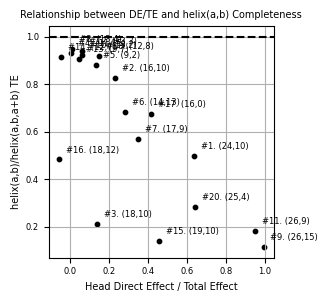

In [18]:
def get_deie_helix_ratio(helix_type='ab', patch_type = 'act'):
    # for high DE/IE heads, we predict helixab is a good model by itself
    if helix_type == 'ab':
        helix_act, helix_path, _, _ = get_intervention_results('helix_ab')
    else:
        helix_act, helix_path, _, _ = get_intervention_results('helix_a_b') 
    helix_all_act, helix_all_path, _, _ = get_intervention_results('helix_a_b_ab')
    _, _, top_heads_tuples, detoie = get_top_act_heads_info()
    helix_ratio = []
    ies = []
    for top_head in top_heads_tuples:
        layer, head = top_head
        ies.append(helix_act)
        if patch_type == 'act':
            ratio = helix_act[layer,head]/helix_all_act[layer,head]
        else:
            ratio = helix_path[layer, head]/helix_all_path[layer,head]
        helix_ratio.append(ratio)
    return top_heads_tuples, detoie, helix_ratio

def plot_helixab_deie(helix_type='ab', patch_type = 'act'):
    top_heads_tuples, detoie, helix_ratio = get_deie_helix_ratio(helix_type, patch_type)
    top_de_heads = identify_top_de_heads()
    helix_type = 'helix_'+helix_type

    
    plt.figure(figsize=(3.25,3))
    
    # Plot and annotate points
    excluded_points = []
    for i, ((layer, head), de_ie, h_ratio) in enumerate(zip(top_heads_tuples, detoie, helix_ratio)):
        if h_ratio > 1.5 or h_ratio < -0.2:
            excluded_points.append((layer, head, h_ratio))
            continue
            
        # if (layer, head) in top_de_heads:
        #     color = 'red'
        #     label = 'heads required for 80% of total DE' if i == 0 else None
        color = 'k'
        label = None
            
        plt.scatter(de_ie, h_ratio, c=color, label=label, s = 10)
        plt.annotate(f'#{i+1}. ({layer},{head})', 
                    (de_ie, h_ratio),
                    xytext=(5, 5),
                    textcoords='offset points',
                    color=color)
    
    # if any((layer, head) in top_de_heads for layer, head in top_heads_tuples):
    #     plt.legend()
    
    # Add horizontal lines at y=0 and y=1
    #plt.axhline(y=0, color='black', linestyle='-')
    plt.axhline(y=1, color='black', linestyle='--')
        
    plt.xlabel('Head Direct Effect / Total Effect')
    plt.ylabel(f'{mapping[helix_type]}/helix(a,b,a+b) TE') 
    plt.title(f'Relationship between DE/TE and {mapping[helix_type]} Completeness')
    
    # Print excluded points
    if excluded_points:
        print("Excluded points with bad ratio")
        for layer, head, ratio in excluded_points:
            # Find the rank of this head
            rank = next(i+1 for i, (l,h) in enumerate(top_heads_tuples) if l == layer and h == head)
            print(f"#{rank}. Layer {layer}, Head {head}: ratio = {ratio:.2f}")

    sdir = f'figs_addition/ab_attn_heads/helix_intervention_results'
    os.makedirs(sdir, exist_ok=True)
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'{sdir}/helix_{helix_type}_{patch_type}_intervention_results.png', bbox_inches = 'tight', dpi = 300)
    plt.show()
    plt.close()

plot_helixab_deie('a_b', 'act')

In [20]:
def categorize_heads(verbose=False):
    # if a high de/ie * helix_ab/helix_all ratio, it's a direct head
    # if a high 1-de/ie * helix_a_b / helix_all ratio, it's an IE head
    top_heads_tuples, detoie, ab_helix = get_deie_helix_ratio(helix_type = 'ab', patch_type = 'act')
    _, _, a_b_helix = get_deie_helix_ratio(helix_type = 'a_b', patch_type = 'act')
    a_b_conf = [min(1,a_b_helix[i]) * min(1,(1-detoie[i])) for i in range(len(detoie))]
    ab_conf = [min(1,ab_helix[i]) * min(1,(detoie[i])) for i in range(len(detoie))]
    total_conf = [max(a_b_conf[i], ab_conf[i]) for i in range(len(ab_conf))]
    
    # Create list of tuples with (total_conf, index) for sorting
    conf_with_idx = [(conf, i) for i, conf in enumerate(total_conf)]
    # Sort by confidence in descending order
    conf_with_idx.sort(reverse=True)

    head_results = []
    conf_results = []
    type_results = []
    if verbose:
        # Print ranked results in table format
        print(f"{'Rank':>4} {'Layer':>5} {'Head':>4} {'Type':>4} {'Conf':>7} {'DE/IE':>7} {'AB':>7} {'A_B':>7}")
        print("-" * 55)
    
    for rank, (conf, idx) in enumerate(conf_with_idx):
        head = top_heads_tuples[idx]
        category = "ab" if ab_conf[idx] > a_b_conf[idx] else "a_b"
        head_results.append((head[0], head[1]))
        conf_results.append(conf)
        type_results.append(category)
        if verbose:
            print(f"#{rank+1:3d} {head[0]:5d} {head[1]:4d} {category:>4s} {conf:7.3f} {detoie[idx]:7.3f} {ab_helix[idx]:7.3f} {a_b_helix[idx]:7.3f}")
    
    return head_results, conf_results, type_results

def get_assignments(k):
    heads, confs, types = categorize_heads()
    results = {}
    confidence = {}
    for i in range(len(heads)):
        if i >= len(heads) - k:  # Bottom k get assigned to mixed
            results[heads[i]] = 'mixed'
        else:
            results[heads[i]] = types[i]
        confidence[heads[i]] = confs[i]
            
    return results, confidence
get_assignments(4)

({(np.int64(26), np.int64(15)): 'ab',
  (np.int64(13), np.int64(4)): 'a_b',
  (np.int64(11), np.int64(15)): 'a_b',
  (np.int64(26), np.int64(9)): 'ab',
  (np.int64(12), np.int64(7)): 'a_b',
  (np.int64(13), np.int64(3)): 'a_b',
  (np.int64(13), np.int64(2)): 'a_b',
  (np.int64(9), np.int64(7)): 'a_b',
  (np.int64(12), np.int64(8)): 'a_b',
  (np.int64(9), np.int64(2)): 'a_b',
  (np.int64(25), np.int64(4)): 'ab',
  (np.int64(16), np.int64(10)): 'a_b',
  (np.int64(24), np.int64(10)): 'ab',
  (np.int64(14), np.int64(13)): 'a_b',
  (np.int64(18), np.int64(12)): 'a_b',
  (np.int64(19), np.int64(10)): 'ab',
  (np.int64(16), np.int64(0)): 'mixed',
  (np.int64(17), np.int64(9)): 'mixed',
  (np.int64(18), np.int64(10)): 'mixed',
  (np.int64(15), np.int64(2)): 'mixed'},
 {(np.int64(26), np.int64(15)): np.float64(0.956742158754696),
  (np.int64(13), np.int64(4)): np.float64(0.9395606226370593),
  (np.int64(11), np.int64(15)): np.float64(0.9293611422169573),
  (np.int64(26), np.int64(9)): np.float6

In [49]:
def topk_heads_act_patch(k):
    assignments, _ = get_assignments(k)
    df = gen_intervention()
    if len(df) > 100:
        df_subset = df.sample(n=100, random_state=42)
    else:
        df_subset = df.copy()
    with torch.no_grad():
        # Take min of next batch_size elements to handle final incomplete batch
        tokens = torch.stack([torch.tensor(x) for x in df_subset['q_tok_original'].values]).to(device)
        a, b, a_b = df_subset['a_intervened'].values, df_subset['b_intervened'].values, df_subset['answer_intervened'].values
        patched_answer_tokens = torch.stack([torch.tensor(x[0]) for x in df_subset['answer_tok_intervened'].values]).to(device)
        nums = np.array([a,b,a_b])
        attn_originals = []
        nums = np.array([a,b,a_b])
        with model.trace(validate=False, remote=remote) as tracer:
            with tracer.invoke(tokens) as invoker:
                for layer in range(NLAYERS):
                    attn_originals.append(model.transformer.h[layer].attn.output[0][:,-1].save())
            original_logits = model.output.logits[:,-1].save()
        attn_hs_patched = {}
        attn_exchanges = {}
        with model.trace(validate=False, remote=remote) as tracer:
            for layer, head in assignments.keys():
                assign = assignments[(layer,head)]
                assign = 'helix_a_b' if assign == 'a_b' else ('helix_ab' if assign == 'ab' else 'helix_a_b_ab')
                exchange = get_fit(nums,assign, layer, head)
                with tracer.invoke(tokens) as invoker:
                    m = model.transformer.h[layer].attn.out_proj.input[:,-1]
                    m = einops.rearrange(m, 'b (nh dh) -> b nh dh',nh=NHEADS)
                    exchange = exchange.clone().detach().to(device).to(dtype=torch.bfloat16)
                    attn_exchanges[(layer, head)] = exchange.save()
                    m[:, head] = exchange
                    model.transformer.h[layer].attn.out_proj.input[:,-1] = einops.rearrange(m, 'b nh dh -> b (nh dh)',nh=NHEADS)
                    attn_patched = model.transformer.h[layer].attn.output[0][:,-1].save()
                    attn_hs_patched[(layer, head)] = attn_patched
        with model.trace(validate=False, remote=remote) as tracer:
            # Patching corrupted run at given layer and token
            with tracer.invoke(tokens) as invoker:
                for layer, head in assignments.keys():
                    assign = assignments[(layer, head)]
                    #print(layer, head, assign)
                    if assign == 'mixed' or assign == 'a_b':
                        # Apply the patch from the clean hidden states to the corrupted hidden state for given layer and head.
                        z_original = model.transformer.h[layer].attn.out_proj.input 
                        z_original = einops.rearrange(z_original, 'b s (nh dh) -> b s nh dh',nh=NHEADS)
                        z_original[:,-1,head,:] = attn_exchanges[layer,head] # ONLY DO EXCHANGE AT LAST SEQPOS
                        z_original = einops.rearrange(z_original, 'b s nh dh -> b s (nh dh)', nh=NHEADS)
                        model.transformer.h[layer].attn.out_proj.input  = z_original
                    if assign == 'a_b':
                        model.transformer.h[-1].output[0][:,-1] += attn_originals[layer] - attn_hs_patched[(layer, head)]
                    if assign == 'ab':
                        model.transformer.h[-1].output[0][:,-1] += attn_hs_patched[(layer, head)] - attn_originals[layer]
                patched_logits = model.output.logits[:,-1].save()
        logdiff = calc_log_diff(original_logits, patched_logits, patched_answer_tokens).mean().item()
    return logdiff
#topk_heads_act_patch(447, 0,99)
#topk_heads_act_patch(20)

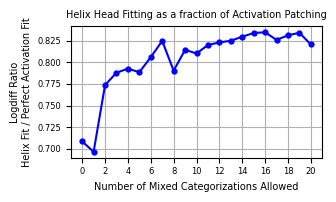

In [63]:
def run_topk_categorization(maxk = 20):
    logdiffs = []
    ks = []
    pbar = tqdm(range(maxk+1))
    for k in pbar:
        logdiff = topk_heads_act_patch(k)
        logdiffs.append(logdiff)
        ks.append(k)
        pbar.set_postfix({'logdiff': logdiff})
    
    with open(f'data_addition/ab_attn_heads/topk_helix_fit_categorizations_logdiffs.pkl', 'wb') as f:
        pickle.dump((ks, logdiffs), f)
def get_topk_categorization():
    with open(f'data_addition/ab_attn_heads/topk_helix_fit_categorizations_logdiffs.pkl', 'rb') as f:
        ks, logdiffs = pickle.load(f)
    with open(f'data_addition/ab_patching/topk_activation_patching_results_0_99.pkl', 'rb') as f:
        data = pickle.load(f)
        max_k_idx = data['k'].index(max(ks))
        comp = data['logdiff'][max_k_idx]
    plt.figure(figsize=(3.25,2))
    plt.plot(ks, [l/comp for l in logdiffs], marker='o', color = 'b', markersize = 3.5)
    plt.xlabel("Number of Mixed Categorizations Allowed")
    plt.xticks(range(0, len(ks), 2))
    plt.ylabel("Logdiff Ratio\nHelix Fit / Perfect Activation Fit")
    plt.title("Helix Head Fitting as a fraction of Activation Patching")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('figs_addition/ab_attn_heads/head_categorization/topk_categorizations.png', bbox_inches='tight', dpi=300)
    plt.show()
get_topk_categorization()
#run_topk_categorization()

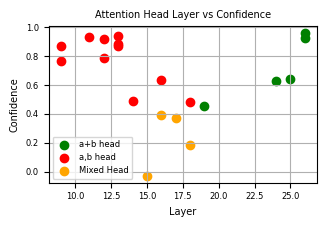

In [88]:
def get_last_token_attn(heads):
    ats = torch.load('data_addition/ab_patching/attention_patterns.pt', weights_only = False).detach().cpu().float()
    last_tok = []
    for layer, head in heads:
        at = ats[layer,:,head].mean(dim = 0)
        last_tok.append(at[-1])
    last_tok = torch.stack(last_tok)
    return last_tok

head_mapping = {'ab': 'a+b head', 'a_b': 'a,b head', 'mixed': "Mixed Head"}
def plot_categorizations(k = 4, toplot = 'last_token_attention'):
    assert toplot in ['last_token_attention', 'a_b_token_attention', 'layer'], f"toplot must be one of ['last_tok_attention', 'a_b_token_attention', 'layer'], got {toplot}"
    head_assignments, confidences = get_assignments(k)
    _, _, top_heads_tuples, _ = get_top_act_heads_info()
    plt.figure(figsize=(3.25,2.25))
    last_tok = get_last_token_attn(top_heads_tuples)
    
    # Create x-axis values based on toplot parameter
    if toplot == 'last_token_attention':
        x_values = last_tok[:,-1]
    elif toplot == 'a_b_token_attention':
        x_values = last_tok[:,-4]+last_tok[:,-2]
    else:
        x_values = [tup[0] for tup in top_heads_tuples]
    
    # Plot each point
    for i, ((layer, head), _) in enumerate(zip(head_assignments.keys(), confidences)):
        # Find the index in top_heads_tuples that matches this (layer,head)
        rank = top_heads_tuples.index((layer, head))
        x_val = x_values[rank]  # Get x value using the rank to maintain correct pairing
        conf = confidences[(layer, head)]
        color = 'red' if head_assignments[(layer, head)] == 'a_b' else ('green' if head_assignments[(layer, head)] == 'ab' else 'orange')
        #print(x_val)
        plt.scatter(x_val, conf, c=color, label=f'{head_mapping[head_assignments[(layer, head)]]}' if i == 0 or head_assignments[(layer, head)] not in [head_assignments[k] for k in list(head_assignments.keys())[:i]] else "")
        # plt.annotate(f'#{rank}\n{layer},{head}', (x_val, conf), color=color, 
        #             xytext=(3, 3), textcoords='offset points')
    
    plt.ylabel("Confidence")
    plt.xlabel(toplot.replace('_',' ').title())
    #plt.xticks(range(0,len(x_values),2))
    plt.title(f"Attention Head {toplot.replace('_',' ').title()} vs Confidence")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'figs_addition/ab_attn_heads/head_categorization/attnhead_categorization_{toplot}.png', bbox_inches='tight', dpi=300)
    plt.show()

plot_categorizations(toplot = 'layer')
    

# Path Patching Heads

In [89]:
def cache_original_corrupted(df_subset):
    batch_size = len(df_subset)
    with torch.no_grad():
        # Take min of next batch_size elements to handle final incomplete batch
        original_tokens = torch.stack([torch.tensor(x) for x in df_subset['q_tok_original'].values]).to(device)
        corrupted_tokens = torch.stack([torch.tensor(x) for x in df_subset['q_tok_intervened'].values]).to(device)
        z_corrupted = {}
        attn_original, mlp_original = [], []
        with model.trace(validate=False, remote=remote) as tracer:
            # STEP 1: Cache all circuit components
            with tracer.invoke(original_tokens) as invoker:
                for layer_idx in range(NLAYERS):
                    attn_original.append(model.transformer.h[layer_idx].attn.output[0][:,-1].save())
                    mlp_original.append(model.transformer.h[layer_idx].mlp.output[:,-1].save())
            with tracer.invoke(corrupted_tokens) as invoker:
                for layer_idx in range(NLAYERS):
                    # attention output for llama models needs to be reshaped to look at individual heads
                    z = model.transformer.h[layer_idx].attn.out_proj.input[:,-1] # dimensions [1x15x4096] [batch x seq x D_MODEL]
                    z_reshaped = einops.rearrange(z, 'b (nh dh) -> b nh dh',nh=NHEADS)
                    for head_idx in range(NHEADS):
                        z_corrupted[layer_idx,head_idx] = z_reshaped[:,head_idx,:].save()
                    z_corrupted[layer_idx] = model.transformer.h[layer_idx].mlp.output[:,-1].save()
            original_logits = model.output.logits[:batch_size,-1].save()
    return z_corrupted, attn_original, mlp_original, original_logits
def path_patch_sender(layer_global, head_global):
    # given some layer, haed. we path patch to figure out where the IE from the head is getting made up from
    # e.g. which paths create IE
    df = gen_intervention()
    if len(df) > 100:
        df_subset = df.sample(n=100, random_state=42)
    else:
        df_subset = df.copy()
    with torch.no_grad():
        # Take min of next batch_size elements to handle final incomplete batch
        original_tokens = torch.stack([torch.tensor(x) for x in df_subset['q_tok_original'].values]).to(device)
        corrupted_answers = torch.stack([torch.tensor(x) for x in df_subset['answer_tok_intervened'].values]).to(device).squeeze(dim=-1)
        z_corrupted, attn_original, mlp_original, original_logits = cache_original_corrupted(df_subset)
        # step 2: run on original tokens. patch in corrupted sender head. for each possibel receive
        z_step2 = {}
        with model.trace(validate=False, remote=remote) as tracer:
            with tracer.invoke(original_tokens) as invoker:
                # patch in the sender node with its corrupted output
                z = model.transformer.h[layer_global].attn.out_proj.input[:,-1]
                z = einops.rearrange(z, 'b (nh dh) -> b nh dh',nh=NHEADS)
                z[:,head_global,:] = z_corrupted[layer_global,head_global]
                z = einops.rearrange(z, 'b nh dh -> b (nh dh)', nh=NHEADS)
                model.transformer.h[layer_global].attn.out_proj.input[:,-1]  = z
                # freeze all later heads and MLPs to their clean values
                z_step2[layer_global] = model.transformer.h[layer_global].mlp.output[:,-1].clone().save()
                model.transformer.h[layer_global].mlp.output[:,-1] = mlp_original[layer_global]
                for layer_idx in range(layer_global+1, NLAYERS):
                    z_target = model.transformer.h[layer_idx].attn.out_proj.input[:,-1] # dimensions [1x15x4096] [batch x seq x D_MODEL]
                    z_target = einops.rearrange(z_target, 'b (nh dh) -> b nh dh',nh=NHEADS)
                    for head_idx in range(NHEADS):
                        z_step2[layer_idx,head_idx] = z_target[:,head_idx,:].clone().save()
                    model.transformer.h[layer_idx].attn.output[0][:,-1] = attn_original[layer_idx]
                    z_step2[layer_idx] = model.transformer.h[layer_idx].mlp.output[:,-1].clone().save()
                    model.transformer.h[layer_idx].mlp.output[:,-1] = mlp_original[layer_idx]
        results = {}
        #bar = tqdm(z_step2.keys())
        for receiver_node in z_step2.keys():#bar:
            with model.trace(validate=False, remote=remote) as tracer:
                with tracer.invoke(original_tokens) as invoker: 
                    if isinstance(receiver_node, int): # MLP
                        model.transformer.h[receiver_node].mlp.output[:,-1] = z_step2[receiver_node]
                    elif isinstance(receiver_node, tuple):
                        layer_idx, head_idx = receiver_node
                         # Apply the patch from the clean hidden states to the corrupted hidden state for given layer and head.
                        z = model.transformer.h[layer_idx].attn.out_proj.input[:,-1]
                        z = einops.rearrange(z, 'b (nh dh) -> b nh dh',nh=NHEADS)
                        z[:,head_idx,:] = z_step2[layer_idx,head_idx]
                        z = einops.rearrange(z, 'b nh dh -> b (nh dh)', nh=NHEADS)
                        model.transformer.h[layer_idx].attn.out_proj.input[:,-1] = z
                patched_logits = model.output.logits[:,-1].save()
            logdiff = calc_log_diff(original_logits, patched_logits, corrupted_answers).mean().item()
            results[receiver_node] = logdiff
            #print(receiver_node, logdiff)
            #bar.set_postfix({'node':receiver_node, 'ldiff': logdiff})
    #return logdiff
    save_path = f"data_addition/ab_attn_heads/path_patching/sender_fixed/L{layer_global}H{head_global}.pkl"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    with open(save_path, 'wb') as f:
        pickle.dump(results, f)
    return results
#path_patch_sender(24,10)

In [90]:
def path_patch_receiver(receiver_layer, receiver_head):
    # given some layer, haed. we path patch to figure out where the IE from the head is getting made up from
    # e.g. which paths create IE
    df = gen_intervention()
    if len(df) > 100:
        df_subset = df.sample(n=100, random_state=42)
    else:
        df_subset = df.copy()
    with torch.no_grad():
        # Take min of next batch_size elements to handle final incomplete batch
        original_tokens = torch.stack([torch.tensor(x) for x in df_subset['q_tok_original'].values]).to(device)
        corrupted_answers = torch.stack([torch.tensor(x) for x in df_subset['answer_tok_intervened'].values]).to(device).squeeze(dim=-1)
        z_corrupted, attn_original, mlp_original, original_logits = cache_original_corrupted(df_subset)
        # step 2: run on original tokens. patch in corrupted sender head. for each possibel receive
        z_step2 = {}
        #for sender_layer, sender_head in tqdm([(l,h) for l in range(receiver_layer) for h in range(NHEADS+1)]):
        for sender_layer, sender_head in [(l,h) for l in range(receiver_layer) for h in range(NHEADS+1)]:
        #for sender_layer, sender_head in tqdm([(l,h) for l in range(11,12) for h in range(NHEADS+1)]):
            with model.trace(validate=False, remote=remote) as tracer:
                with tracer.invoke(original_tokens) as invoker:
                    # patch in the sender node with its corrupted output
                    if sender_head != NHEADS: #normal attn head
                        z = model.transformer.h[sender_layer].attn.out_proj.input[:,-1]
                        z = einops.rearrange(z, 'b (nh dh) -> b nh dh',nh=NHEADS)
                        z[:,sender_head,:] = z_corrupted[sender_layer,sender_head]
                        z = einops.rearrange(z, 'b nh dh -> b (nh dh)', nh=NHEADS)
                        model.transformer.h[sender_layer].attn.out_proj.input[:,-1]  = z
                        # freeze all later heads and MLPs to their clean values
                        model.transformer.h[sender_layer].mlp.output[:,-1] = mlp_original[sender_layer]
                    else: #MLP 
                        model.transformer.h[sender_layer].mlp.output[:,-1] = z_corrupted[sender_layer]
                    for layer_idx in range(sender_layer+1, receiver_layer):
                        model.transformer.h[layer_idx].attn.output[0][:,-1] = attn_original[layer_idx]
                        model.transformer.h[layer_idx].mlp.output[:,-1] = mlp_original[layer_idx]
                    z_target = model.transformer.h[receiver_layer].attn.out_proj.input[:,-1] # dimensions [1x15x4096] [batch x seq x D_MODEL]
                    z_target = einops.rearrange(z_target, 'b (nh dh) -> b nh dh',nh=NHEADS)
                    key = (sender_layer, sender_head) if sender_head != NHEADS else sender_layer
                    z_step2[key] = z_target[:,receiver_head,:].clone().save()
        results = {}
        #bar = tqdm(z_step2.keys())
        for sender_node in z_step2.keys():#bar:
            with model.trace(validate=False, remote=remote) as tracer:
                with tracer.invoke(original_tokens) as invoker: 
                    #print(sender_node)
                    # Apply the patch from the clean hidden states to the corrupted hidden state for given layer and head.
                    z = model.transformer.h[receiver_layer].attn.out_proj.input[:,-1]
                    z = einops.rearrange(z, 'b (nh dh) -> b nh dh',nh=NHEADS)
                    z[:,receiver_head,:] = z_step2[sender_node]
                    z = einops.rearrange(z, 'b nh dh -> b (nh dh)', nh=NHEADS)
                    model.transformer.h[receiver_layer].attn.out_proj.input[:,-1] = z
                patched_logits = model.output.logits[:,-1].save()
            logdiff = calc_log_diff(original_logits, patched_logits, corrupted_answers).mean().item()
            results[sender_node] = logdiff
            #print(receiver_node, logdiff)
            #bar.set_postfix({'node':sender_node, 'ldiff': logdiff})
    #return logdiff
    save_path = f"data_addition/ab_attn_heads/path_patching/receiver_fixed/L{receiver_layer}H{receiver_head}.pkl"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    with open(save_path, 'wb') as f:
        pickle.dump(results, f)
    return results
#results = path_patch_receiver(24,10)

In [91]:
def run_all_pathpatch(fixed = 'sender'):
    _, _, top_heads_tuples, _ = get_top_act_heads_info()
    bar = tqdm(top_heads_tuples)
    for head in bar:
        if fixed == 'sender':
            path_patch_sender(head[0], head[1])
        elif fixed == 'receiver':
            path_patch_receiver(head[0], head[1])
        bar.set_postfix({'layer':head[0], 'head':head[1]})
#run_all_pathpatch('receiver')

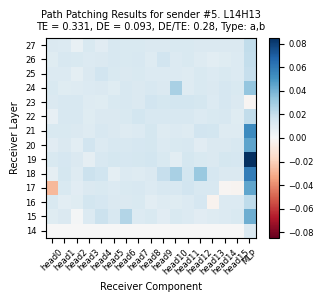

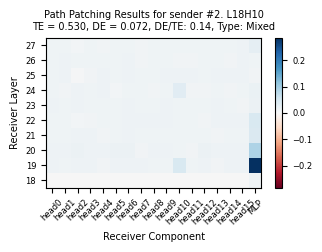

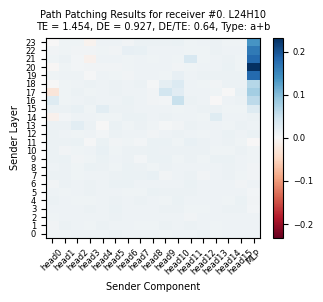

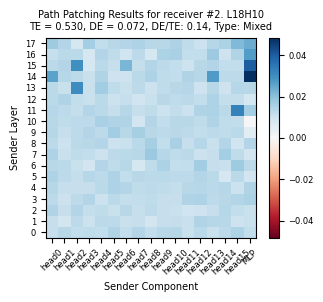

In [23]:
mapped_type = {'ab':'a+b', 'a_b':'a,b', 'mixed': 'Mixed'}
def plot_pathpatch(layer_global, head_global, fixed = 'sender'):
    # Read in data
    act_values, path_values, top_heads_tuples, ratios = get_top_act_heads_info()
    head_rank = next(i for i, h in enumerate(top_heads_tuples) if h[0] == layer_global and h[1] == head_global)
    ie, de, ratio = act_values[head_rank], path_values[head_rank], ratios[head_rank]
    assignments, confidences= get_assignments(k=4)
    assignment = assignments[layer_global,head_global]#, confidence = assignments[layer,head], confidences[head_rank]
    # Find rank of this head in top_heads_tuples
    
    save_path = f"data_addition/ab_attn_heads/path_patching/{fixed}_fixed/L{layer_global}H{head_global}.pkl"
    with open(save_path, 'rb') as f:
        results = pickle.load(f)

    # Find min layer in results
    min_layer = float('inf')
    max_layer = -float('inf')
    for receiver_node in results.keys():
        if not isinstance(receiver_node, tuple):
            min_layer = min(min_layer,int(receiver_node))
            max_layer = max(max_layer, int(receiver_node))
    n_rows = max_layer - min_layer + 1
    matrix = np.zeros((n_rows, NHEADS + 1)) # +1 for MLP column
    for key, value in results.items():
        if isinstance(key, tuple): # attn head
            layer, head = key
            matrix[layer - min_layer, head] = value
            
        else: # mlp 
            matrix[key - min_layer, -1] = value
            
            
    # Create labels
    x_labels = [f'head{i}' for i in range(NHEADS)] + ['MLP']
    y_labels = list(range(min_layer, max_layer+1))
    
    # Plot
    plt.figure(figsize=(3.25,min(n_rows/4, 3)))
    vmax = max(abs(matrix.min()), abs(matrix.max()))
    im = plt.imshow(matrix[::-1], cmap='RdBu', aspect='auto', vmin=-vmax, vmax=vmax, origin='upper')
    plt.colorbar(im)
    
    # # Find top 10 values and their positions
    # flat_indices = np.argsort(matrix.ravel())[-10:]  # Get indices of top 10 values
    # row_indices, col_indices = np.unravel_index(flat_indices, matrix.shape)
    # top_values = matrix[row_indices, col_indices]
    
    # # Annotate values > 0.3*vmax
    # for row, col, val in zip(row_indices, col_indices, top_values):
    #     if val > 0.3 * vmax:
    #         plt.text(col, n_rows-1-row, f'{val:.3f}', ha='center', va='center', color='white', fontsize = 8)
    
    plt.xticks(range(NHEADS + 1), x_labels, rotation=45)
    plt.yticks(range(n_rows), y_labels[::-1])  # Reverse y labels
    
    plt.title(f'Path Patching Results for {fixed} #{head_rank}. L{layer_global}H{head_global}\nTE = {ie:.3f}, DE = {de:.3f}, DE/TE: {ratio:.2f}, Type: {mapped_type[assignment]}')
    opposite = 'Receiver' if fixed == 'sender' else 'Sender'
    plt.xlabel(f'{opposite} Component')
    plt.ylabel(f'{opposite} Layer')
    
    # Save plot
    save_dir = f"figs_addition/ab_attn_heads/path_patching/{fixed}_fixed"
    os.makedirs(save_dir, exist_ok=True)
    plt.tight_layout()
    plt.savefig(f"{save_dir}/{head_rank}. L{layer_global}H{head_global}.png", bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

def plot_all_path_patch(fixed = 'sender'):
    _, _, top_heads_tuples, _ = get_top_act_heads_info()
    for head in top_heads_tuples:
        plot_pathpatch(head[0], head[1],fixed = fixed)
plot_pathpatch(14,13, fixed = 'sender')
plot_pathpatch(18,10, fixed = 'sender')
plot_pathpatch(24,10, fixed = 'receiver')
plot_pathpatch(18,10, fixed = 'receiver')
#plot_all_path_patch('receiver')

In [109]:
def plot_mlp_distribution(fixed = 'sender',head_type = 'a_b'):
    assignments, _ = get_assignments(k=4)
    plt.figure(figsize=(6,4))
    
    all_values = np.zeros((NLAYERS,))
    min_layers = float('inf')
    for head in assignments:
        if assignments[head] == head_type:
            save_path = f"data_addition/ab_attn_heads/path_patching/{fixed}_fixed/L{head[0]}H{head[1]}.pkl"
            with open(save_path, 'rb') as f:
                results = pickle.load(f)
                mlps = {int(k):results[k] for k in results.keys() if not isinstance(k, tuple)}
                
                layers = list(mlps.keys())
                min_layers = min(min(layers), min_layers)
                values = list(mlps.values())
                for i in range(len(layers)):
                    all_values[layers[i]]+=values[i]
                plt.plot(layers, values, alpha=0.3, label = f'{(int(head[0]), int(head[1]))}')
    plt.plot(range(min_layers, NLAYERS), all_values[min_layers:], color='black', linewidth=2, label='Sum')
        
    plt.title(f'MLP Logit Differences Across Layers\nFixed {fixed} {head_type} heads')
    plt.xlabel('Layer')
    plt.ylabel('Logit Difference')
    plt.xticks(range(min_layers, NLAYERS), [str(i) for i in range(min_layers, NLAYERS)], rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'figs_addition/ab_attn_heads/path_patching/mlp_{fixed}_fixed_{head_type}_heads.png')
    plt.show()

#plot_mlp_distribution(fixed = 'receiver', head_type = 'mixed')

# Logit Lens Attn Heads

In [54]:
def get_output_tokens(mina = 0, maxa = 99):
    # answers range from 0, 99 * 2 
    avals, toks = [], []
    for a in range(mina, 2 * maxa + 1):
        atok = model.tokenizer(f'{a}')['input_ids']
        avals.append(a)
        toks.append(atok[0])
    return avals, toks


def logit_lens_attn_head(layer, head):
    df = get_correct_df()
    if len(df) > 100:
        df_subset = df.sample(n=100, random_state=42)
    else:
        df_subset = df.copy()
    with torch.no_grad():
        # Take min of next batch_size elements to handle final incomplete batch
        tokens = torch.stack([torch.tensor(x) for x in df_subset['q_tok'].values]).to(device)
        with model.trace(validate=False, remote=remote) as tracer:
            with tracer.invoke(tokens) as invoker:
                # patch in the sender node with its corrupted output
                z = model.transformer.h[head].attn.out_proj.input[:,-1]
                z = einops.rearrange(z, 'b (nh dh) -> b nh dh',nh=NHEADS)
                for head_idx in range(NHEADS):
                    if head_idx == head:
                        continue
                    z[:,head_idx] = 0 # 0 out all non head components
                z = einops.rearrange(z, 'b nh dh -> b (nh dh)', nh=NHEADS)
                model.transformer.h[layer].attn.out_proj.input[:,-1]  = z
                attn = model.transformer.h[layer].attn.output[0][:,-1]
                #attn = model.transformer.h[layer].output[0][:,-1].save()
                logits  = model.lm_head(model.transformer.ln_f(attn)).save()
    vals,toks = get_output_tokens()
    # Index logits at token positions to get predictions for each possible answer
    logits = logits[:, toks].cpu().float().detach() # Shape: (100, 199) - for each example, get logits for all possible answer tokens
    a,b = df_subset['a'].values, df_subset['b'].values
    
    # Save outputs to data file
    save_dir = 'data_addition/ab_attn_heads/logit_lens'
    os.makedirs(save_dir, exist_ok=True)
    np.savez(f'{save_dir}/layer_{layer}_head_{head}.npz',
             a=a, b=b, vals=vals, logits=logits.cpu().numpy())
    
    return a,b,vals, logits

def run_all_logitlens():
    _,_, heads, _ = get_top_act_heads_info(k = 20)
    for layer_head in tqdm(heads):
        layer, head = layer_head
        logit_lens_attn_head(layer,head)

#print(len(vals))
#run_all_logitlens()

100%|██████████| 20/20 [00:03<00:00,  6.17it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

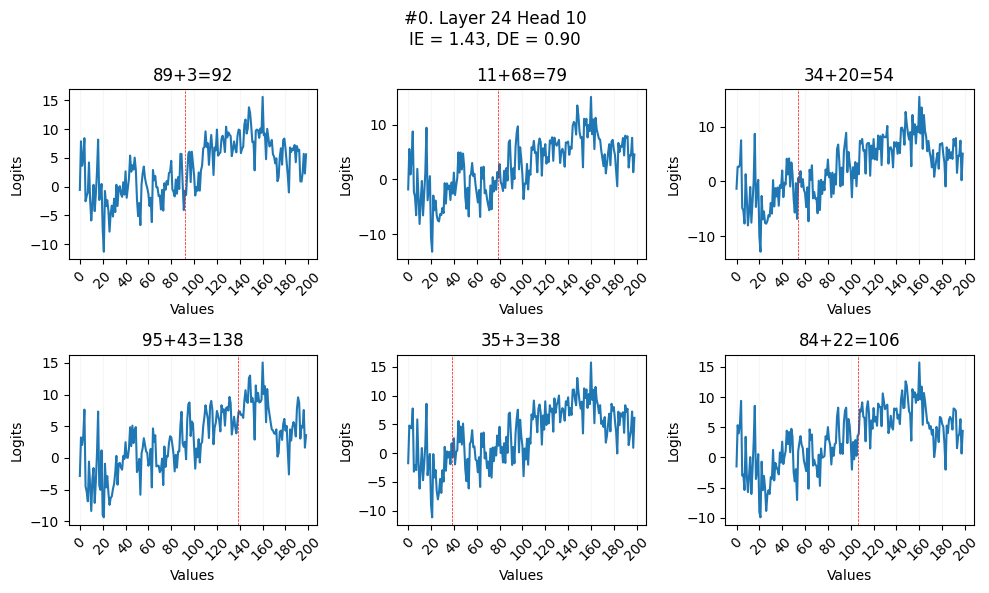

  5%|▌         | 1/20 [00:00<00:13,  1.43it/s]

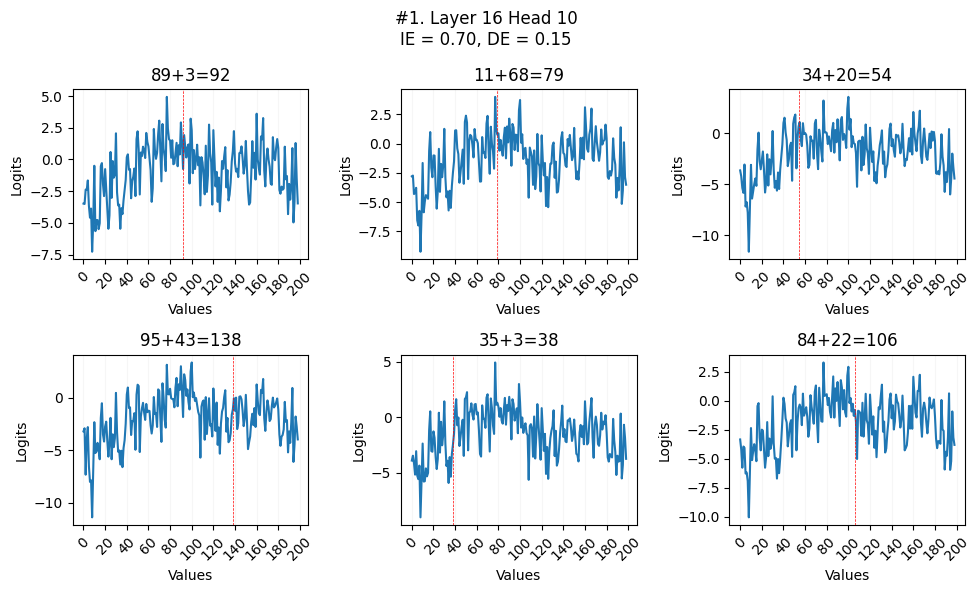

 10%|█         | 2/20 [00:01<00:12,  1.46it/s]

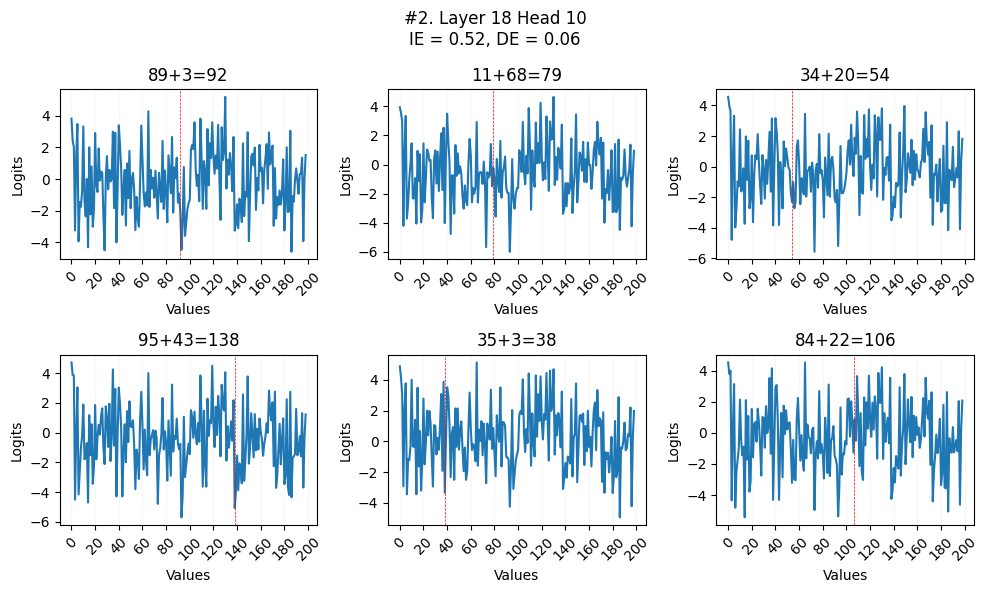

 15%|█▌        | 3/20 [00:02<00:11,  1.44it/s]

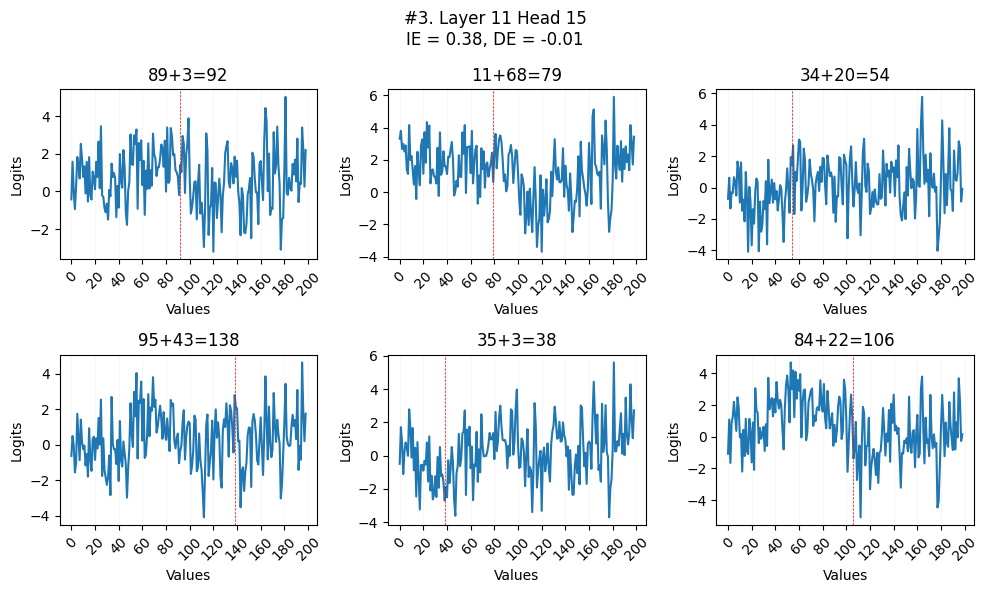

 20%|██        | 4/20 [00:02<00:11,  1.44it/s]

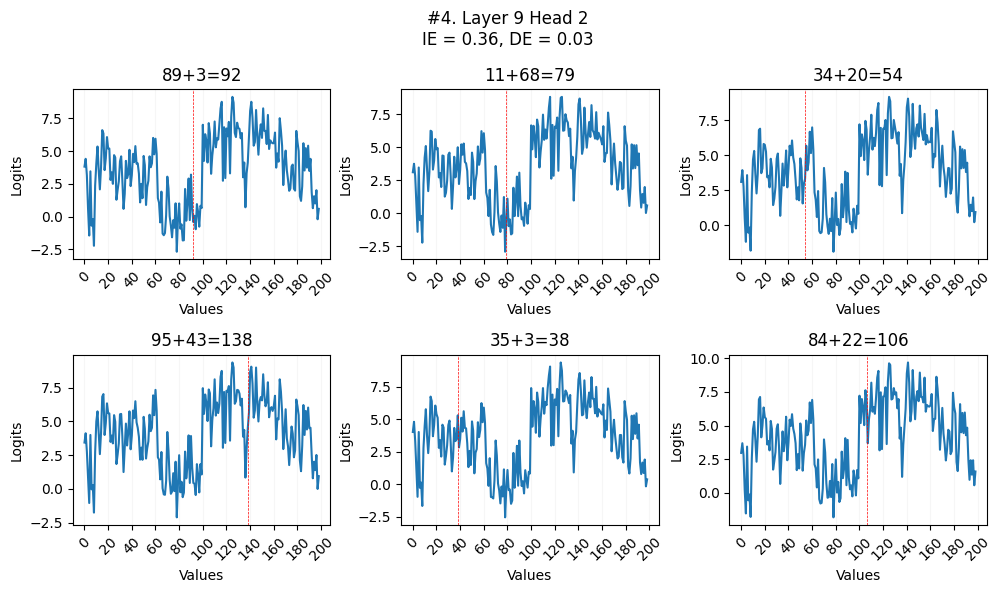

 25%|██▌       | 5/20 [00:03<00:10,  1.42it/s]

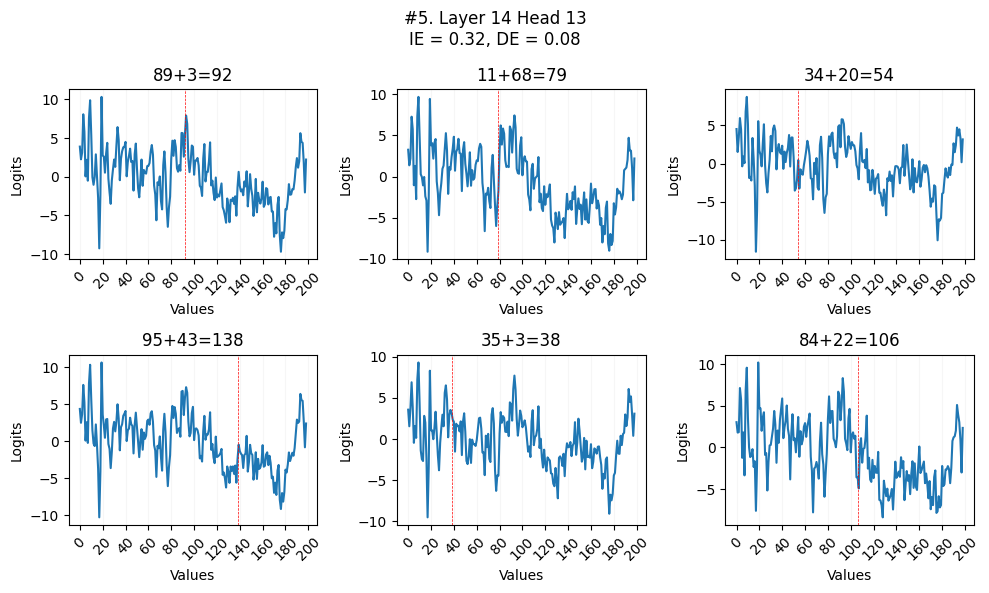

 30%|███       | 6/20 [00:04<00:11,  1.22it/s]

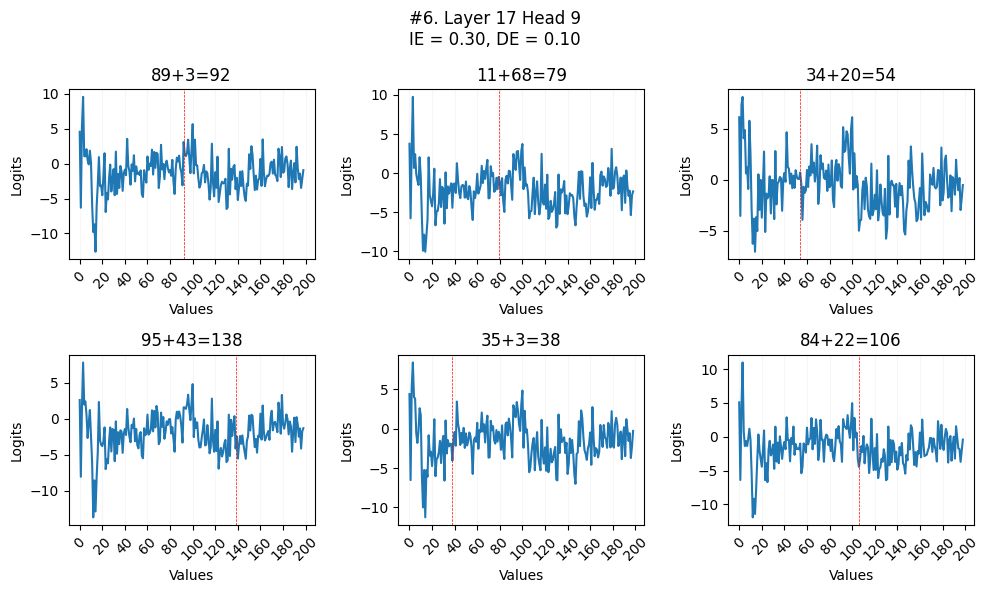

 35%|███▌      | 7/20 [00:05<00:10,  1.30it/s]

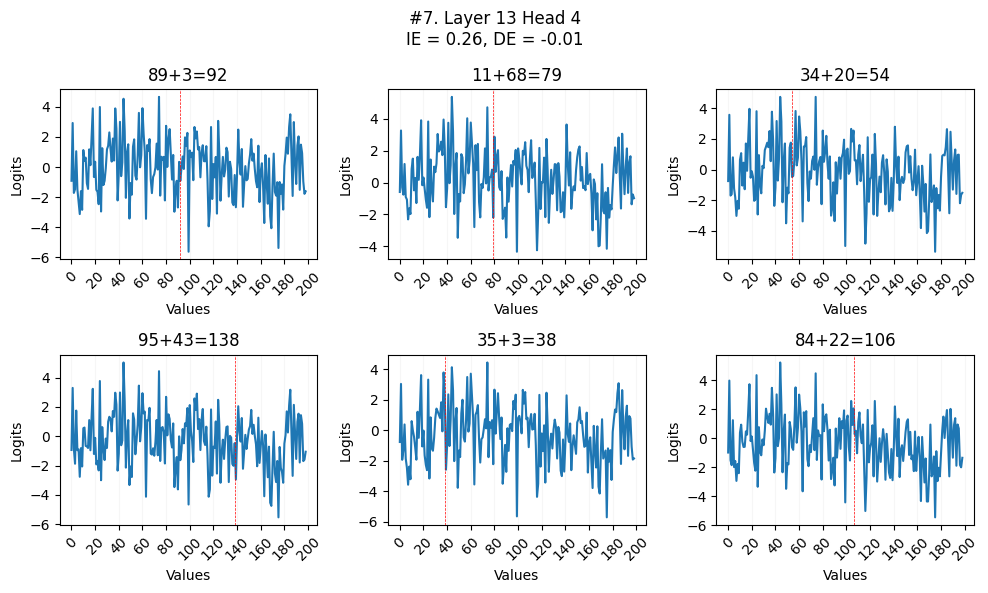

 40%|████      | 8/20 [00:05<00:09,  1.33it/s]

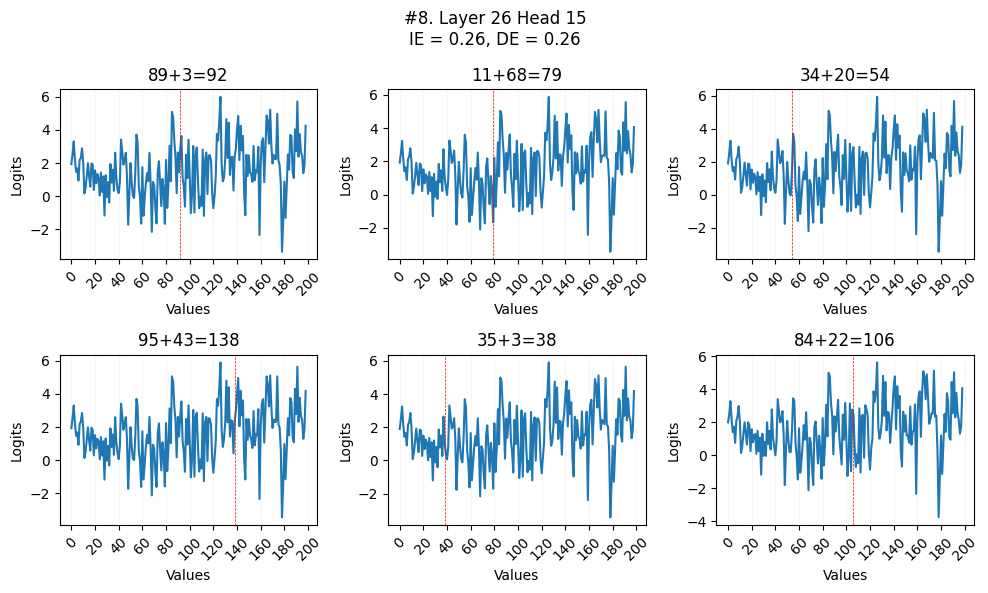

 45%|████▌     | 9/20 [00:06<00:08,  1.36it/s]

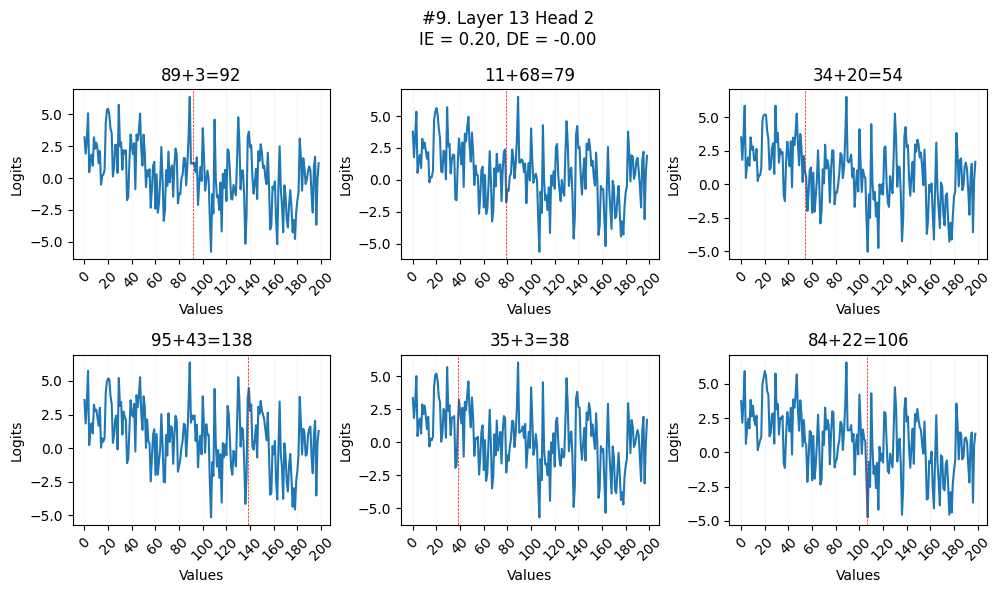

 50%|█████     | 10/20 [00:07<00:07,  1.38it/s]

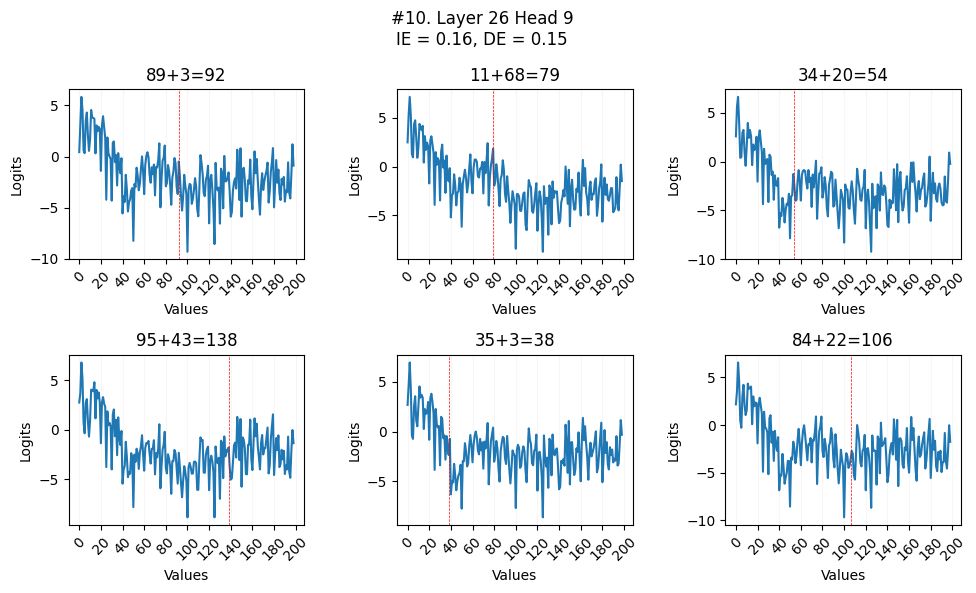

 55%|█████▌    | 11/20 [00:07<00:06,  1.41it/s]

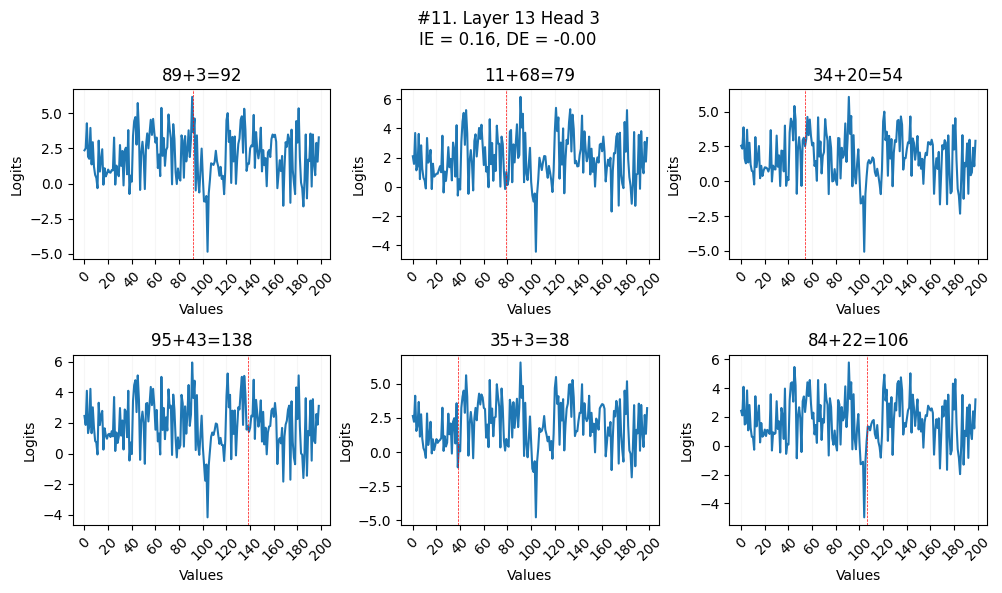

 60%|██████    | 12/20 [00:08<00:05,  1.41it/s]

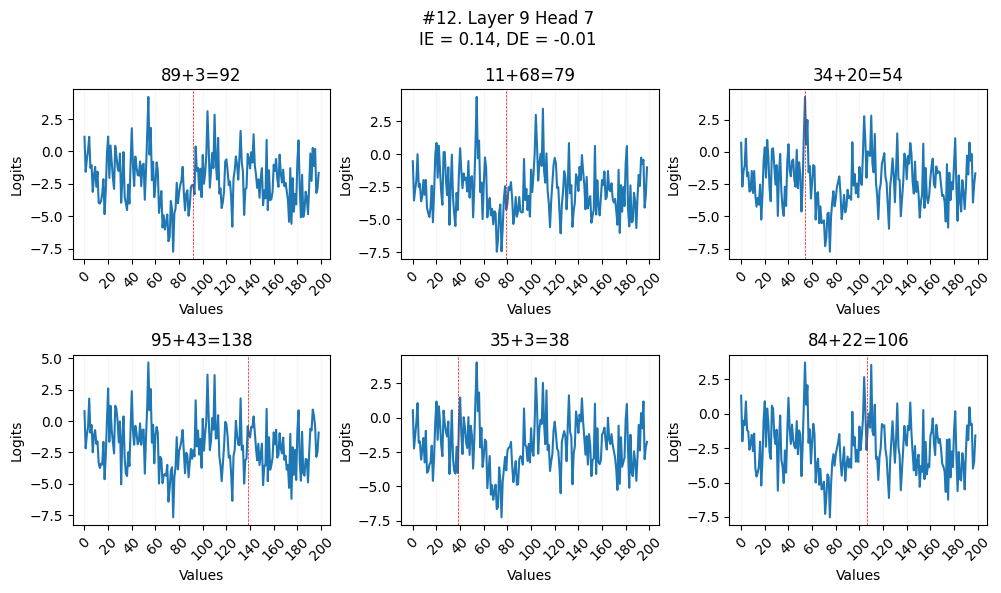

 65%|██████▌   | 13/20 [00:09<00:04,  1.41it/s]

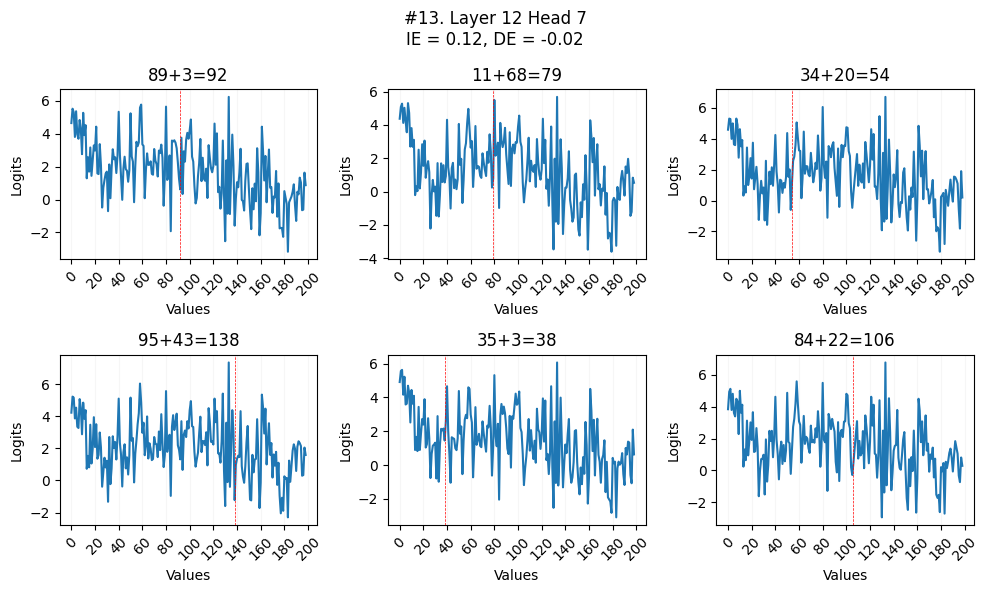

 70%|███████   | 14/20 [00:10<00:04,  1.42it/s]

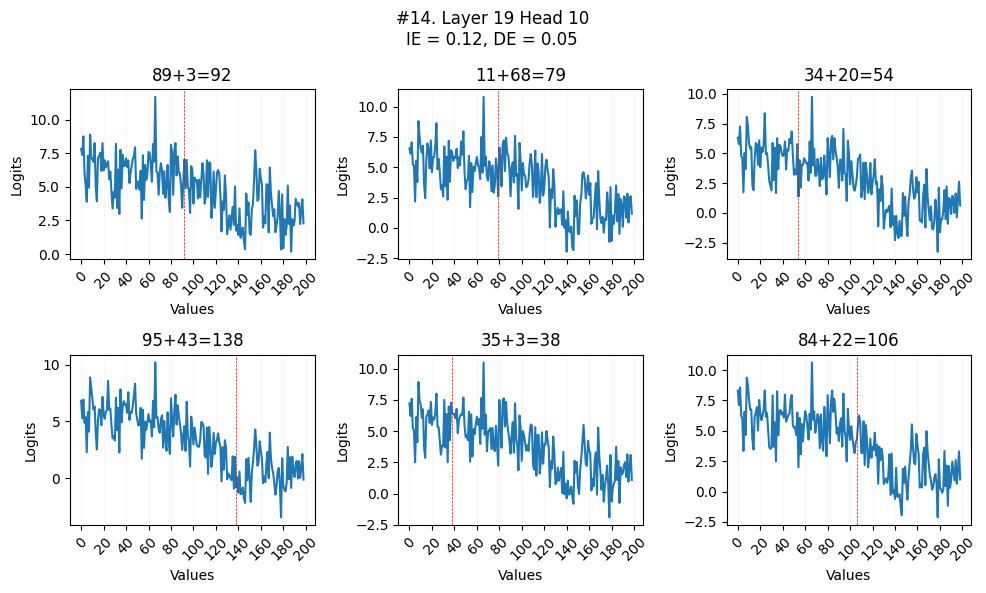

 75%|███████▌  | 15/20 [00:10<00:03,  1.42it/s]

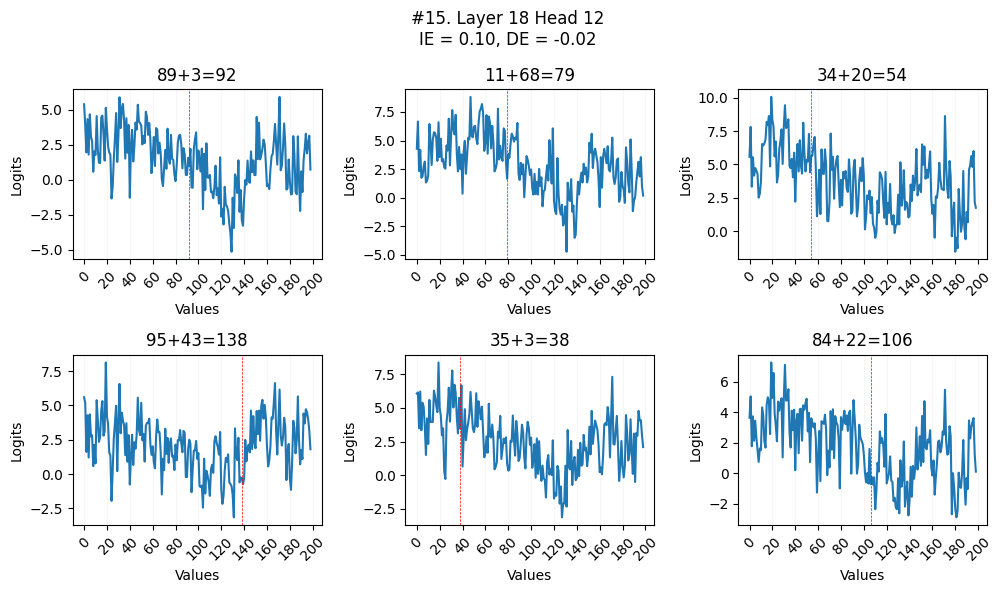

 80%|████████  | 16/20 [00:11<00:03,  1.23it/s]

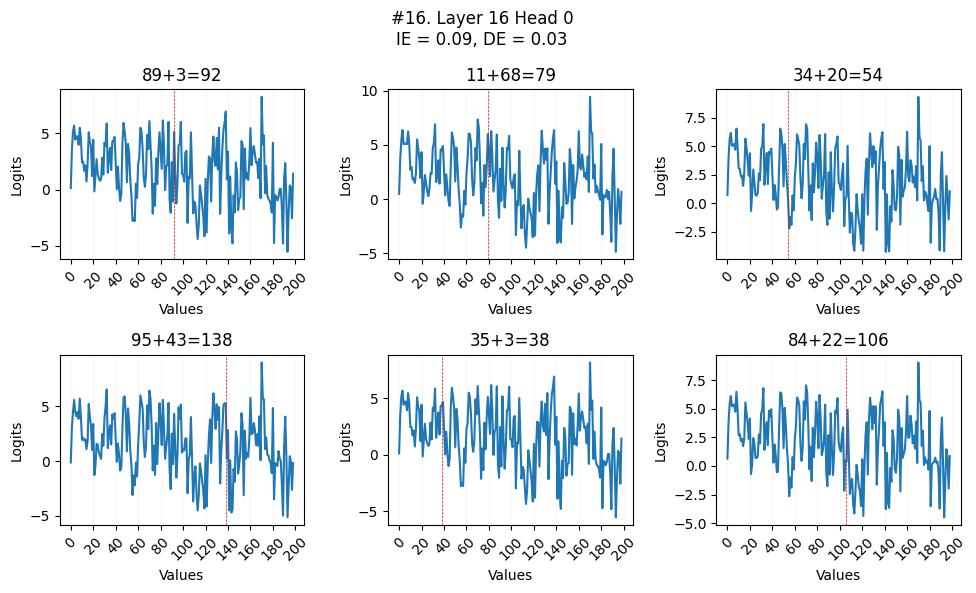

 85%|████████▌ | 17/20 [00:12<00:02,  1.29it/s]

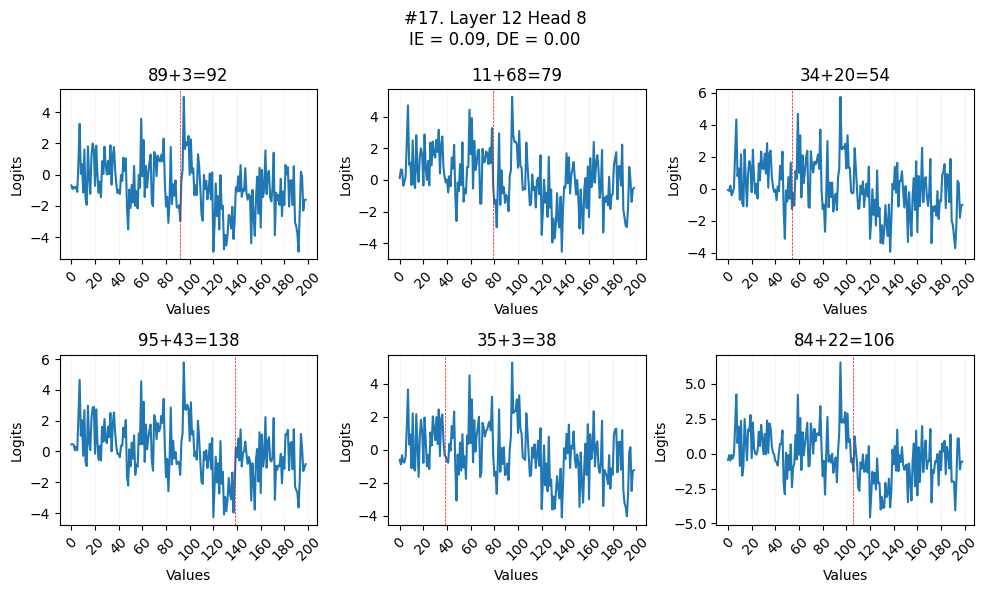

 90%|█████████ | 18/20 [00:13<00:01,  1.33it/s]

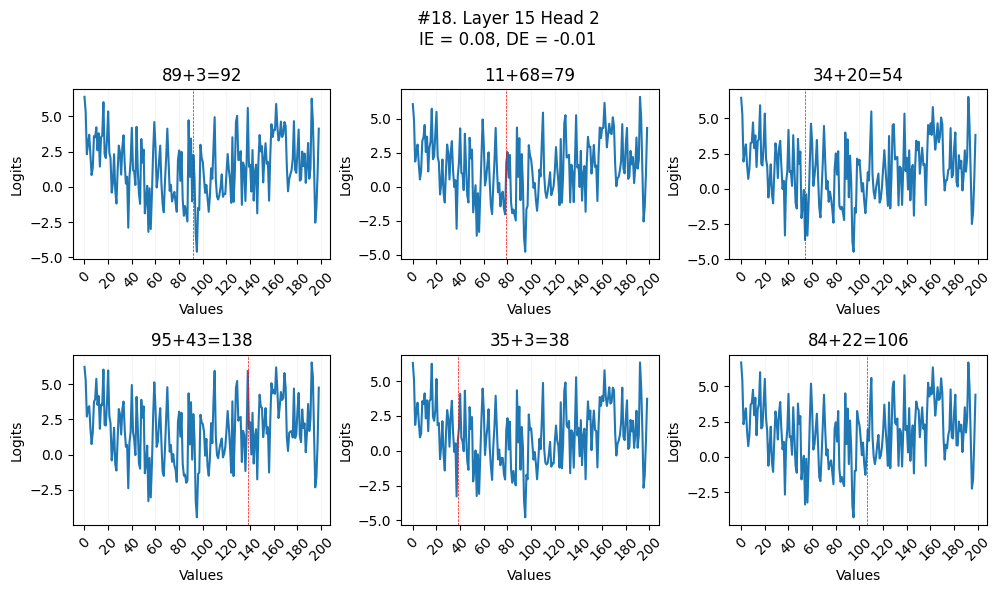

 95%|█████████▌| 19/20 [00:13<00:00,  1.36it/s]

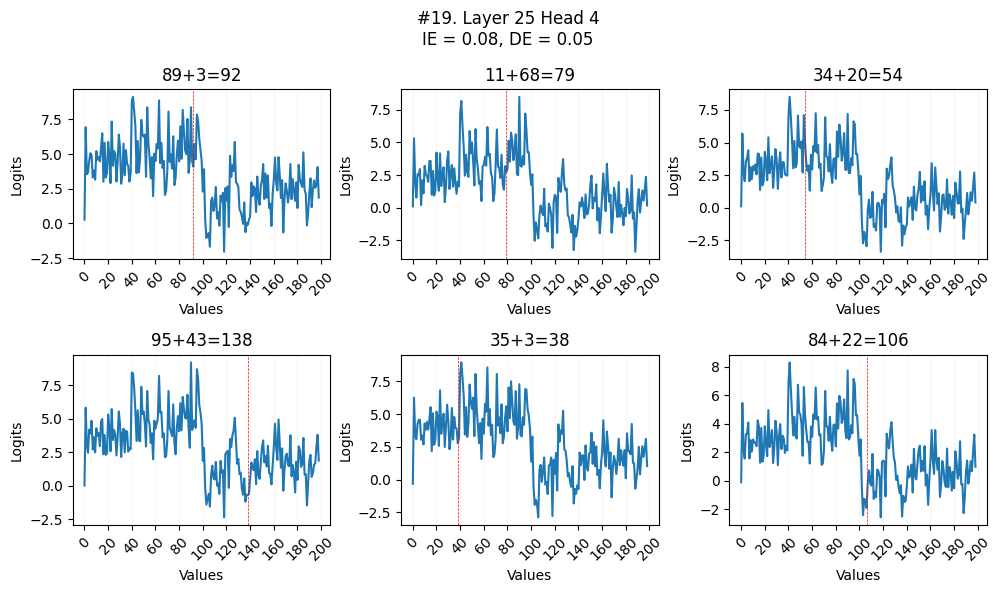

100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


In [65]:
def get_logit_lens(layer, head):
    # Load saved outputs from data file
    save_dir = 'data_addition/ab_attn_heads/logit_lens'
    data = np.load(f'{save_dir}/layer_{layer}_head_{head}.npz')
    a = data['a']
    b = data['b'] 
    vals = data['vals']
    logits = torch.tensor(data['logits'])
    
    return a,b,vals, logits

def plot_logit_lens(layer, head):
    _,_, heads, _ = get_top_act_heads_info(k = 20)
    rank = next(i for i, (l,h) in enumerate(heads) if l == layer and h == head)
    np.random.seed(42)  # Set consistent random seed
    a, b, vals, logits = get_logit_lens(layer,head)
    logits = logits.float().detach().cpu()

    fig, axes = plt.subplots(2, 3, figsize=(10, 6))
    axes = axes.flatten()

    # Get 6 random indices for plotting
    random_indices = np.random.choice(logits.shape[0], size=6, replace=False)
    _, _, full_act, full_path = get_intervention_results('helix_a_b_ab')
    ie, de = full_act[layer, head], full_path[layer, head]
    for i, ax in enumerate(axes):
        random_idx = random_indices[i]
        ax.plot(vals, logits[random_idx].cpu())
        # Add title with a+b equation
        ax.set_title(f'{a[random_idx]}+{b[random_idx]}={a[random_idx]+b[random_idx]}')
        # Add vertical line at correct answer
        ax.axvline(x=a[random_idx]+b[random_idx], color='red', linestyle='--', lw = 0.5)
        # Add light grid lines every 10 units
        ax.grid(True, which='major', axis='x', linestyle='-', alpha=0.1)
        ax.set_xticks(range(0, max(vals)+10, 20))
        ax.set_xticklabels(range(0, max(vals)+10, 20), rotation=45)
        ax.set_xlabel('Values')
        ax.set_ylabel('Logits')
    plt.suptitle(f'#{rank}. Layer {layer} Head {head}\nIE = {ie:.2f}, DE = {de:.2f}')
        
    plt.tight_layout()
    plt.savefig(f'figs_addition/ab_attn_heads/logit_lens/{rank}. L{layer}H{head}.png')
    plt.show()

def plot_all_logit_lens():
    _,_, heads, _ = get_top_act_heads_info(k = 20)
    for layer_head in tqdm(heads):
        layer, head = layer_head
        plot_logit_lens(layer,head)
#plot_logit_lens(24,10)
#plot_all_logit_lens()

# Dashboard

In [80]:
def get_plots(k):
    _,_, heads, _ = get_top_act_heads_info(k = 20)
    layer, head = heads[k]
    assignments, confidences = get_assignments(k=4)
    assign, conf = assignments[layer, head], confidences[layer, head]
    helix_type = f'helix_{assign}' if (assign == 'ab' or assign == 'a_b') else 'helix_a_b_ab'
    helix_act, _, full_act, full_path = get_intervention_results(helix_type)
    ie, de, helix_ie = full_act[layer, head], full_path[layer, head], helix_act[layer, head]
    metrics = {'ie': ie, 'de/ie': de/ie, 'helix ie/ie': helix_ie/ie, 'conf': conf, 'layer':layer, 'head':head,'assign':assign}
    figures = {}
    figures['attn_pattern'] = f'figs_addition/ab_attn_heads/topk_head_attentionpatterns/{k+1}. L{layer}H{head}.png'
    figures['output_pca'] = f'figs_addition/ab_attn_heads/2d_pca/{k}.L{layer}H{head}.png'
    figures['helix_comp'] = f'figs_addition/ab_attn_heads/helix_fit_component_graphs/{helix_type}/{k}.L{layer}H{head}.png'
    figures['path_patch_sender'] = f'figs_addition/ab_attn_heads/path_patching/sender_fixed/{k}. L{layer}H{head}.png'
    figures['path_patch_receiver'] = f'figs_addition/ab_attn_heads/path_patching/receiver_fixed/{k}. L{layer}H{head}.png'
    figures['logit_lens'] = f'figs_addition/ab_attn_heads/logit_lens/{k}. L{layer}H{head}.png'
    return metrics, figures


get_plots(0)

({'ie': np.float64(1.429375),
  'de/ie': np.float64(0.6280061215566244),
  'helix ie/ie': np.float64(0.7033231307389594),
  'conf': np.float64(0.6255171607232113),
  'layer': np.int64(24),
  'head': np.int64(10),
  'assign': 'ab'},
 {'attn_pattern': 'figs_addition/ab_attn_heads/topk_head_attentionpatterns/1. L24H10.png',
  'output_pca': 'figs_addition/ab_attn_heads/2d_pca/0.L24H10.png',
  'helix_comp': 'figs_addition/ab_attn_heads/helix_fit_component_graphs/helix_ab/0.L24H10.png',
  'path_patch_sender': 'figs_addition/ab_attn_heads/path_patching/sender_fixed/0. L24H10.png',
  'path_patch_receiver': 'figs_addition/ab_attn_heads/path_patching/receiver_fixed/0. L24H10.png',
  'logit_lens': 'figs_addition/ab_attn_heads/logit_lens/0. L24H10.png'})

In [81]:
import os
import panel as pn

pn.extension()

def generate_dashboard(k):
    # Get metrics and figures from get_plots
    metrics, figures = get_plots(k)
    
    # Create metrics display
    metrics_md = "## Metrics\n"
    for key, val in metrics.items():
        metrics_md += f"**{key}:** {val}\n"
    metrics_display = pn.pane.Markdown(metrics_md, width=300)

    # Create image panes for each figure
    figure_panes = []
    for name, path in figures.items():
        abs_path = os.path.abspath(path)
        figure_panes.append(pn.pane.Image(abs_path, width=600))
        figure_panes.append(pn.pane.Markdown(f"### {name}"))

    # Return the dashboard layout
    return pn.Row(
        pn.Column(
            f"# Head Analysis k={k}",
            metrics_display,
            *figure_panes
        )
    )

# Create a TextInput widget
text_input = pn.widgets.TextInput(name="Enter k", placeholder="Type k here")

# Create an interactive Panel app
def update_dashboard(event):
    k = int(text_input.value.strip())
    try:
        # Update the layout with the new dashboard
        dashboard[:] = [generate_dashboard(k)]
    except Exception as e:
        dashboard[:] = [pn.pane.Markdown(f"### Error: {e}")]

# Attach callback to text input
text_input.param.watch(update_dashboard, "value")

# Initial dashboard layout
dashboard = pn.Column(f"# Type k to Load Head Analysis")

# Combine text input and dashboard
app = pn.Column(text_input, dashboard)

# Serve the app
app.show()

Launching server at http://localhost:44681
